In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_075_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3086158, 828)
(3086158, 8)
validation
(415168, 828)
(415168, 8)
test
(419234, 828)
(419234, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/309 [..............................] - ETA: 7:00 - loss: 2.4400 - STD: 0.1338 - MAE: 0.2187

  4/309 [..............................] - ETA: 5s - loss: 2.2080 - STD: 0.0636 - MAE: 0.2184  

  7/309 [..............................] - ETA: 5s - loss: 2.1658 - STD: 0.0489 - MAE: 0.2185

 10/309 [..............................] - ETA: 5s - loss: 2.1545 - STD: 0.0453 - MAE: 0.2185

 13/309 [>.............................] - ETA: 5s - loss: 2.1417 - STD: 0.0411 - MAE: 0.2185

 16/309 [>.............................] - ETA: 5s - loss: 2.1297 - STD: 0.0369 - MAE: 0.2185

 19/309 [>.............................] - ETA: 5s - loss: 2.1215 - STD: 0.0338 - MAE: 0.2185

 22/309 [=>............................] - ETA: 5s - loss: 2.1161 - STD: 0.0321 - MAE: 0.2185

 25/309 [=>............................] - ETA: 5s - loss: 2.1117 - STD: 0.0307 - MAE: 0.2184

 28/309 [=>............................] - ETA: 4s - loss: 2.1073 - STD: 0.0292 - MAE: 0.2184

 31/309 [==>...........................] - ETA: 4s - loss: 2.1035 - STD: 0.0278 - MAE: 0.2184

 34/309 [==>...........................] - ETA: 4s - loss: 2.0999 - STD: 0.0265 - MAE: 0.2184

 38/309 [==>...........................] - ETA: 4s - loss: 2.0951 - STD: 0.0253 - MAE: 0.2183

 41/309 [==>...........................] - ETA: 4s - loss: 2.0909 - STD: 0.0247 - MAE: 0.2182

 44/309 [===>..........................] - ETA: 4s - loss: 2.0856 - STD: 0.0244 - MAE: 0.2181

 47/309 [===>..........................] - ETA: 4s - loss: 2.0794 - STD: 0.0246 - MAE: 0.2179

 50/309 [===>..........................] - ETA: 4s - loss: 2.0719 - STD: 0.0255 - MAE: 0.2176

 53/309 [====>.........................] - ETA: 4s - loss: 2.0636 - STD: 0.0268 - MAE: 0.2173

 56/309 [====>.........................] - ETA: 4s - loss: 2.0544 - STD: 0.0286 - MAE: 0.2168

 59/309 [====>.........................] - ETA: 4s - loss: 2.0453 - STD: 0.0306 - MAE: 0.2164

 62/309 [=====>........................] - ETA: 4s - loss: 2.0357 - STD: 0.0327 - MAE: 0.2159

 65/309 [=====>........................] - ETA: 4s - loss: 2.0261 - STD: 0.0347 - MAE: 0.2154

 68/309 [=====>........................] - ETA: 4s - loss: 2.0162 - STD: 0.0365 - MAE: 0.2149

 71/309 [=====>........................] - ETA: 4s - loss: 2.0063 - STD: 0.0384 - MAE: 0.2145

 74/309 [======>.......................] - ETA: 4s - loss: 1.9959 - STD: 0.0402 - MAE: 0.2140

 77/309 [======>.......................] - ETA: 4s - loss: 1.9850 - STD: 0.0419 - MAE: 0.2135

 79/309 [======>.......................] - ETA: 5s - loss: 1.9790 - STD: 0.0431 - MAE: 0.2131

 82/309 [======>.......................] - ETA: 5s - loss: 1.9679 - STD: 0.0449 - MAE: 0.2126

 85/309 [=======>......................] - ETA: 5s - loss: 1.9565 - STD: 0.0467 - MAE: 0.2120

 89/309 [=======>......................] - ETA: 5s - loss: 1.9415 - STD: 0.0491 - MAE: 0.2113

 92/309 [=======>......................] - ETA: 5s - loss: 1.9305 - STD: 0.0509 - MAE: 0.2107

 95/309 [========>.....................] - ETA: 5s - loss: 1.9197 - STD: 0.0527 - MAE: 0.2101

 99/309 [========>.....................] - ETA: 5s - loss: 1.9056 - STD: 0.0550 - MAE: 0.2093

102/309 [========>.....................] - ETA: 4s - loss: 1.8951 - STD: 0.0567 - MAE: 0.2087

105/309 [=========>....................] - ETA: 4s - loss: 1.8848 - STD: 0.0584 - MAE: 0.2082

108/309 [=========>....................] - ETA: 4s - loss: 1.8745 - STD: 0.0601 - MAE: 0.2076

112/309 [=========>....................] - ETA: 4s - loss: 1.8613 - STD: 0.0623 - MAE: 0.2068

115/309 [==========>...................] - ETA: 4s - loss: 1.8514 - STD: 0.0639 - MAE: 0.2062

118/309 [==========>...................] - ETA: 4s - loss: 1.8414 - STD: 0.0655 - MAE: 0.2056

121/309 [==========>...................] - ETA: 4s - loss: 1.8315 - STD: 0.0671 - MAE: 0.2049

125/309 [===========>..................] - ETA: 4s - loss: 1.8186 - STD: 0.0692 - MAE: 0.2041

129/309 [===========>..................] - ETA: 4s - loss: 1.8058 - STD: 0.0713 - MAE: 0.2033

132/309 [===========>..................] - ETA: 3s - loss: 1.7962 - STD: 0.0729 - MAE: 0.2026

135/309 [============>.................] - ETA: 3s - loss: 1.7870 - STD: 0.0745 - MAE: 0.2020

139/309 [============>.................] - ETA: 3s - loss: 1.7751 - STD: 0.0765 - MAE: 0.2012

142/309 [============>.................] - ETA: 3s - loss: 1.7667 - STD: 0.0780 - MAE: 0.2006

145/309 [=============>................] - ETA: 3s - loss: 1.7582 - STD: 0.0794 - MAE: 0.2000

148/309 [=============>................] - ETA: 3s - loss: 1.7499 - STD: 0.0809 - MAE: 0.1994

151/309 [=============>................] - ETA: 3s - loss: 1.7420 - STD: 0.0822 - MAE: 0.1988

154/309 [=============>................] - ETA: 3s - loss: 1.7340 - STD: 0.0836 - MAE: 0.1982

158/309 [==============>...............] - ETA: 3s - loss: 1.7237 - STD: 0.0854 - MAE: 0.1975

161/309 [==============>...............] - ETA: 3s - loss: 1.7162 - STD: 0.0867 - MAE: 0.1969

164/309 [==============>...............] - ETA: 3s - loss: 1.7090 - STD: 0.0879 - MAE: 0.1964

168/309 [===============>..............] - ETA: 2s - loss: 1.6994 - STD: 0.0896 - MAE: 0.1957

171/309 [===============>..............] - ETA: 2s - loss: 1.6925 - STD: 0.0908 - MAE: 0.1952

174/309 [===============>..............] - ETA: 2s - loss: 1.6855 - STD: 0.0920 - MAE: 0.1946

178/309 [================>.............] - ETA: 2s - loss: 1.6767 - STD: 0.0935 - MAE: 0.1940

181/309 [================>.............] - ETA: 2s - loss: 1.6703 - STD: 0.0946 - MAE: 0.1935

184/309 [================>.............] - ETA: 2s - loss: 1.6641 - STD: 0.0957 - MAE: 0.1930

188/309 [=================>............] - ETA: 2s - loss: 1.6560 - STD: 0.0971 - MAE: 0.1924

191/309 [=================>............] - ETA: 2s - loss: 1.6501 - STD: 0.0982 - MAE: 0.1919

194/309 [=================>............] - ETA: 2s - loss: 1.6443 - STD: 0.0992 - MAE: 0.1914

197/309 [==================>...........] - ETA: 2s - loss: 1.6387 - STD: 0.1002 - MAE: 0.1910

201/309 [==================>...........] - ETA: 2s - loss: 1.6314 - STD: 0.1015 - MAE: 0.1904

204/309 [==================>...........] - ETA: 2s - loss: 1.6261 - STD: 0.1024 - MAE: 0.1900

207/309 [===================>..........] - ETA: 2s - loss: 1.6208 - STD: 0.1033 - MAE: 0.1896

210/309 [===================>..........] - ETA: 2s - loss: 1.6155 - STD: 0.1042 - MAE: 0.1892

213/309 [===================>..........] - ETA: 1s - loss: 1.6103 - STD: 0.1051 - MAE: 0.1888

216/309 [===================>..........] - ETA: 1s - loss: 1.6054 - STD: 0.1059 - MAE: 0.1884

219/309 [====================>.........] - ETA: 1s - loss: 1.6005 - STD: 0.1068 - MAE: 0.1880

222/309 [====================>.........] - ETA: 1s - loss: 1.5957 - STD: 0.1076 - MAE: 0.1876

225/309 [====================>.........] - ETA: 1s - loss: 1.5910 - STD: 0.1084 - MAE: 0.1872

228/309 [=====================>........] - ETA: 1s - loss: 1.5863 - STD: 0.1092 - MAE: 0.1868

232/309 [=====================>........] - ETA: 1s - loss: 1.5805 - STD: 0.1103 - MAE: 0.1864

235/309 [=====================>........] - ETA: 1s - loss: 1.5760 - STD: 0.1111 - MAE: 0.1860

239/309 [======================>.......] - ETA: 1s - loss: 1.5703 - STD: 0.1121 - MAE: 0.1855

242/309 [======================>.......] - ETA: 1s - loss: 1.5661 - STD: 0.1128 - MAE: 0.1852

245/309 [======================>.......] - ETA: 1s - loss: 1.5620 - STD: 0.1135 - MAE: 0.1848

248/309 [=======================>......] - ETA: 1s - loss: 1.5579 - STD: 0.1142 - MAE: 0.1845

251/309 [=======================>......] - ETA: 1s - loss: 1.5538 - STD: 0.1149 - MAE: 0.1842

254/309 [=======================>......] - ETA: 1s - loss: 1.5497 - STD: 0.1156 - MAE: 0.1838

258/309 [========================>.....] - ETA: 1s - loss: 1.5445 - STD: 0.1165 - MAE: 0.1834

261/309 [========================>.....] - ETA: 0s - loss: 1.5407 - STD: 0.1172 - MAE: 0.1831

264/309 [========================>.....] - ETA: 0s - loss: 1.5371 - STD: 0.1178 - MAE: 0.1828

267/309 [========================>.....] - ETA: 0s - loss: 1.5333 - STD: 0.1184 - MAE: 0.1825

270/309 [=========================>....] - ETA: 0s - loss: 1.5299 - STD: 0.1191 - MAE: 0.1822

273/309 [=========================>....] - ETA: 0s - loss: 1.5264 - STD: 0.1197 - MAE: 0.1819

276/309 [=========================>....] - ETA: 0s - loss: 1.5229 - STD: 0.1203 - MAE: 0.1816

279/309 [==========================>...] - ETA: 0s - loss: 1.5196 - STD: 0.1209 - MAE: 0.1813

282/309 [==========================>...] - ETA: 0s - loss: 1.5162 - STD: 0.1215 - MAE: 0.1810

285/309 [==========================>...] - ETA: 0s - loss: 1.5129 - STD: 0.1221 - MAE: 0.1807

289/309 [===========================>..] - ETA: 0s - loss: 1.5086 - STD: 0.1228 - MAE: 0.1803

292/309 [===========================>..] - ETA: 0s - loss: 1.5054 - STD: 0.1234 - MAE: 0.1801

295/309 [===========================>..] - ETA: 0s - loss: 1.5022 - STD: 0.1240 - MAE: 0.1798

298/309 [===========================>..] - ETA: 0s - loss: 1.4991 - STD: 0.1245 - MAE: 0.1795

302/309 [============================>.] - ETA: 0s - loss: 1.4950 - STD: 0.1252 - MAE: 0.1792

306/309 [============================>.] - ETA: 0s - loss: 1.4910 - STD: 0.1259 - MAE: 0.1788

309/309 [==============================] - 8s 23ms/step - loss: 1.4880 - STD: 0.1264 - MAE: 0.1786 - val_loss: 1.2503 - val_STD: 0.1732 - val_MAE: 0.1575


Epoch 2/10000


  1/309 [..............................] - ETA: 16s - loss: 1.1884 - STD: 0.1771 - MAE: 0.1534

  4/309 [..............................] - ETA: 5s - loss: 1.1782 - STD: 0.1790 - MAE: 0.1522 

  8/309 [..............................] - ETA: 5s - loss: 1.1805 - STD: 0.1794 - MAE: 0.1521

 11/309 [>.............................] - ETA: 5s - loss: 1.1807 - STD: 0.1792 - MAE: 0.1522

 15/309 [>.............................] - ETA: 4s - loss: 1.1801 - STD: 0.1793 - MAE: 0.1522

 18/309 [>.............................] - ETA: 4s - loss: 1.1780 - STD: 0.1796 - MAE: 0.1519

 22/309 [=>............................] - ETA: 4s - loss: 1.1795 - STD: 0.1797 - MAE: 0.1520

 25/309 [=>............................] - ETA: 4s - loss: 1.1792 - STD: 0.1799 - MAE: 0.1519

 28/309 [=>............................] - ETA: 4s - loss: 1.1783 - STD: 0.1801 - MAE: 0.1517

 31/309 [==>...........................] - ETA: 4s - loss: 1.1765 - STD: 0.1802 - MAE: 0.1516

 34/309 [==>...........................] - ETA: 4s - loss: 1.1759 - STD: 0.1804 - MAE: 0.1515

 37/309 [==>...........................] - ETA: 4s - loss: 1.1758 - STD: 0.1806 - MAE: 0.1514

 40/309 [==>...........................] - ETA: 4s - loss: 1.1750 - STD: 0.1807 - MAE: 0.1513

 43/309 [===>..........................] - ETA: 4s - loss: 1.1751 - STD: 0.1808 - MAE: 0.1513

 46/309 [===>..........................] - ETA: 4s - loss: 1.1740 - STD: 0.1809 - MAE: 0.1512

 49/309 [===>..........................] - ETA: 4s - loss: 1.1732 - STD: 0.1810 - MAE: 0.1511

 53/309 [====>.........................] - ETA: 4s - loss: 1.1725 - STD: 0.1811 - MAE: 0.1510

 56/309 [====>.........................] - ETA: 4s - loss: 1.1717 - STD: 0.1813 - MAE: 0.1509

 59/309 [====>.........................] - ETA: 4s - loss: 1.1709 - STD: 0.1814 - MAE: 0.1509

 62/309 [=====>........................] - ETA: 4s - loss: 1.1699 - STD: 0.1816 - MAE: 0.1507

 65/309 [=====>........................] - ETA: 4s - loss: 1.1695 - STD: 0.1817 - MAE: 0.1507

 68/309 [=====>........................] - ETA: 4s - loss: 1.1684 - STD: 0.1818 - MAE: 0.1506

 71/309 [=====>........................] - ETA: 4s - loss: 1.1671 - STD: 0.1819 - MAE: 0.1505

 75/309 [======>.......................] - ETA: 4s - loss: 1.1657 - STD: 0.1821 - MAE: 0.1503

 78/309 [======>.......................] - ETA: 3s - loss: 1.1645 - STD: 0.1822 - MAE: 0.1502

 81/309 [======>.......................] - ETA: 3s - loss: 1.1636 - STD: 0.1824 - MAE: 0.1501

 84/309 [=======>......................] - ETA: 3s - loss: 1.1631 - STD: 0.1825 - MAE: 0.1500

 87/309 [=======>......................] - ETA: 3s - loss: 1.1629 - STD: 0.1826 - MAE: 0.1500

 91/309 [=======>......................] - ETA: 3s - loss: 1.1618 - STD: 0.1827 - MAE: 0.1499

 94/309 [========>.....................] - ETA: 3s - loss: 1.1607 - STD: 0.1828 - MAE: 0.1498

 97/309 [========>.....................] - ETA: 3s - loss: 1.1598 - STD: 0.1829 - MAE: 0.1497

100/309 [========>.....................] - ETA: 3s - loss: 1.1590 - STD: 0.1830 - MAE: 0.1496

103/309 [=========>....................] - ETA: 3s - loss: 1.1581 - STD: 0.1832 - MAE: 0.1495

107/309 [=========>....................] - ETA: 3s - loss: 1.1576 - STD: 0.1833 - MAE: 0.1494

111/309 [=========>....................] - ETA: 3s - loss: 1.1566 - STD: 0.1835 - MAE: 0.1493

114/309 [==========>...................] - ETA: 3s - loss: 1.1557 - STD: 0.1836 - MAE: 0.1492

117/309 [==========>...................] - ETA: 3s - loss: 1.1552 - STD: 0.1838 - MAE: 0.1492

120/309 [==========>...................] - ETA: 3s - loss: 1.1545 - STD: 0.1839 - MAE: 0.1491

123/309 [==========>...................] - ETA: 3s - loss: 1.1536 - STD: 0.1840 - MAE: 0.1490

127/309 [===========>..................] - ETA: 3s - loss: 1.1520 - STD: 0.1841 - MAE: 0.1488

130/309 [===========>..................] - ETA: 3s - loss: 1.1510 - STD: 0.1843 - MAE: 0.1487

133/309 [===========>..................] - ETA: 3s - loss: 1.1502 - STD: 0.1844 - MAE: 0.1487

137/309 [============>.................] - ETA: 2s - loss: 1.1488 - STD: 0.1845 - MAE: 0.1485

141/309 [============>.................] - ETA: 2s - loss: 1.1476 - STD: 0.1847 - MAE: 0.1484

144/309 [============>.................] - ETA: 2s - loss: 1.1469 - STD: 0.1848 - MAE: 0.1483

148/309 [=============>................] - ETA: 2s - loss: 1.1463 - STD: 0.1850 - MAE: 0.1482

152/309 [=============>................] - ETA: 2s - loss: 1.1455 - STD: 0.1852 - MAE: 0.1481

155/309 [==============>...............] - ETA: 2s - loss: 1.1457 - STD: 0.1853 - MAE: 0.1481

159/309 [==============>...............] - ETA: 2s - loss: 1.1454 - STD: 0.1854 - MAE: 0.1480

163/309 [==============>...............] - ETA: 2s - loss: 1.1450 - STD: 0.1855 - MAE: 0.1480

167/309 [===============>..............] - ETA: 2s - loss: 1.1446 - STD: 0.1856 - MAE: 0.1479

171/309 [===============>..............] - ETA: 2s - loss: 1.1439 - STD: 0.1857 - MAE: 0.1478

175/309 [===============>..............] - ETA: 2s - loss: 1.1431 - STD: 0.1858 - MAE: 0.1477

179/309 [================>.............] - ETA: 2s - loss: 1.1422 - STD: 0.1860 - MAE: 0.1476

182/309 [================>.............] - ETA: 2s - loss: 1.1416 - STD: 0.1861 - MAE: 0.1476

186/309 [=================>............] - ETA: 2s - loss: 1.1406 - STD: 0.1862 - MAE: 0.1475

190/309 [=================>............] - ETA: 2s - loss: 1.1399 - STD: 0.1863 - MAE: 0.1474

194/309 [=================>............] - ETA: 1s - loss: 1.1391 - STD: 0.1864 - MAE: 0.1473

198/309 [==================>...........] - ETA: 1s - loss: 1.1384 - STD: 0.1865 - MAE: 0.1472

201/309 [==================>...........] - ETA: 1s - loss: 1.1380 - STD: 0.1866 - MAE: 0.1472

205/309 [==================>...........] - ETA: 1s - loss: 1.1373 - STD: 0.1867 - MAE: 0.1471

208/309 [===================>..........] - ETA: 1s - loss: 1.1368 - STD: 0.1868 - MAE: 0.1470

211/309 [===================>..........] - ETA: 1s - loss: 1.1363 - STD: 0.1869 - MAE: 0.1470

214/309 [===================>..........] - ETA: 1s - loss: 1.1357 - STD: 0.1870 - MAE: 0.1469

217/309 [====================>.........] - ETA: 1s - loss: 1.1350 - STD: 0.1871 - MAE: 0.1468

220/309 [====================>.........] - ETA: 1s - loss: 1.1345 - STD: 0.1872 - MAE: 0.1468

223/309 [====================>.........] - ETA: 1s - loss: 1.1340 - STD: 0.1873 - MAE: 0.1467

226/309 [====================>.........] - ETA: 1s - loss: 1.1335 - STD: 0.1873 - MAE: 0.1467

229/309 [=====================>........] - ETA: 1s - loss: 1.1329 - STD: 0.1874 - MAE: 0.1466

233/309 [=====================>........] - ETA: 1s - loss: 1.1322 - STD: 0.1875 - MAE: 0.1465

236/309 [=====================>........] - ETA: 1s - loss: 1.1317 - STD: 0.1876 - MAE: 0.1465

239/309 [======================>.......] - ETA: 1s - loss: 1.1312 - STD: 0.1877 - MAE: 0.1464

243/309 [======================>.......] - ETA: 1s - loss: 1.1303 - STD: 0.1878 - MAE: 0.1463

247/309 [======================>.......] - ETA: 1s - loss: 1.1296 - STD: 0.1879 - MAE: 0.1462

250/309 [=======================>......] - ETA: 1s - loss: 1.1291 - STD: 0.1880 - MAE: 0.1462

253/309 [=======================>......] - ETA: 0s - loss: 1.1285 - STD: 0.1881 - MAE: 0.1461

257/309 [=======================>......] - ETA: 0s - loss: 1.1276 - STD: 0.1882 - MAE: 0.1460

260/309 [========================>.....] - ETA: 0s - loss: 1.1270 - STD: 0.1883 - MAE: 0.1460

263/309 [========================>.....] - ETA: 0s - loss: 1.1263 - STD: 0.1883 - MAE: 0.1459

266/309 [========================>.....] - ETA: 0s - loss: 1.1256 - STD: 0.1884 - MAE: 0.1458

269/309 [=========================>....] - ETA: 0s - loss: 1.1250 - STD: 0.1885 - MAE: 0.1458

273/309 [=========================>....] - ETA: 0s - loss: 1.1247 - STD: 0.1886 - MAE: 0.1457

277/309 [=========================>....] - ETA: 0s - loss: 1.1241 - STD: 0.1887 - MAE: 0.1456

281/309 [==========================>...] - ETA: 0s - loss: 1.1234 - STD: 0.1888 - MAE: 0.1455

284/309 [==========================>...] - ETA: 0s - loss: 1.1230 - STD: 0.1889 - MAE: 0.1455

287/309 [==========================>...] - ETA: 0s - loss: 1.1225 - STD: 0.1890 - MAE: 0.1454

291/309 [===========================>..] - ETA: 0s - loss: 1.1219 - STD: 0.1891 - MAE: 0.1454

295/309 [===========================>..] - ETA: 0s - loss: 1.1212 - STD: 0.1892 - MAE: 0.1453

298/309 [===========================>..] - ETA: 0s - loss: 1.1207 - STD: 0.1892 - MAE: 0.1452

301/309 [============================>.] - ETA: 0s - loss: 1.1202 - STD: 0.1893 - MAE: 0.1452

305/309 [============================>.] - ETA: 0s - loss: 1.1196 - STD: 0.1894 - MAE: 0.1451

308/309 [============================>.] - ETA: 0s - loss: 1.1191 - STD: 0.1895 - MAE: 0.1451

309/309 [==============================] - 6s 19ms/step - loss: 1.1189 - STD: 0.1895 - MAE: 0.1450 - val_loss: 1.1600 - val_STD: 0.1908 - val_MAE: 0.1470


Epoch 3/10000


  1/309 [..............................] - ETA: 14s - loss: 1.0739 - STD: 0.1959 - MAE: 0.1404

  5/309 [..............................] - ETA: 5s - loss: 1.0718 - STD: 0.1969 - MAE: 0.1396 

  8/309 [..............................] - ETA: 5s - loss: 1.0719 - STD: 0.1969 - MAE: 0.1397

 11/309 [>.............................] - ETA: 5s - loss: 1.0681 - STD: 0.1968 - MAE: 0.1396

 14/309 [>.............................] - ETA: 5s - loss: 1.0637 - STD: 0.1972 - MAE: 0.1392

 18/309 [>.............................] - ETA: 4s - loss: 1.0620 - STD: 0.1975 - MAE: 0.1390

 21/309 [=>............................] - ETA: 4s - loss: 1.0648 - STD: 0.1976 - MAE: 0.1391

 24/309 [=>............................] - ETA: 4s - loss: 1.0659 - STD: 0.1976 - MAE: 0.1391

 28/309 [=>............................] - ETA: 4s - loss: 1.0653 - STD: 0.1975 - MAE: 0.1391

 31/309 [==>...........................] - ETA: 4s - loss: 1.0647 - STD: 0.1975 - MAE: 0.1391

 34/309 [==>...........................] - ETA: 4s - loss: 1.0640 - STD: 0.1976 - MAE: 0.1390

 37/309 [==>...........................] - ETA: 4s - loss: 1.0636 - STD: 0.1976 - MAE: 0.1390

 40/309 [==>...........................] - ETA: 4s - loss: 1.0631 - STD: 0.1976 - MAE: 0.1389

 43/309 [===>..........................] - ETA: 4s - loss: 1.0619 - STD: 0.1977 - MAE: 0.1388

 46/309 [===>..........................] - ETA: 4s - loss: 1.0613 - STD: 0.1977 - MAE: 0.1388

 49/309 [===>..........................] - ETA: 4s - loss: 1.0602 - STD: 0.1978 - MAE: 0.1387

 52/309 [====>.........................] - ETA: 4s - loss: 1.0593 - STD: 0.1978 - MAE: 0.1387

 55/309 [====>.........................] - ETA: 4s - loss: 1.0587 - STD: 0.1979 - MAE: 0.1386

 58/309 [====>.........................] - ETA: 4s - loss: 1.0581 - STD: 0.1980 - MAE: 0.1385

 62/309 [=====>........................] - ETA: 4s - loss: 1.0578 - STD: 0.1981 - MAE: 0.1384

 65/309 [=====>........................] - ETA: 4s - loss: 1.0574 - STD: 0.1981 - MAE: 0.1384

 68/309 [=====>........................] - ETA: 4s - loss: 1.0562 - STD: 0.1982 - MAE: 0.1383

 72/309 [=====>........................] - ETA: 4s - loss: 1.0557 - STD: 0.1983 - MAE: 0.1383

 76/309 [======>.......................] - ETA: 3s - loss: 1.0554 - STD: 0.1984 - MAE: 0.1382

 79/309 [======>.......................] - ETA: 3s - loss: 1.0580 - STD: 0.1985 - MAE: 0.1383

 82/309 [======>.......................] - ETA: 3s - loss: 1.0583 - STD: 0.1985 - MAE: 0.1383

 85/309 [=======>......................] - ETA: 3s - loss: 1.0589 - STD: 0.1986 - MAE: 0.1383

 89/309 [=======>......................] - ETA: 3s - loss: 1.0592 - STD: 0.1986 - MAE: 0.1383

 93/309 [========>.....................] - ETA: 3s - loss: 1.0587 - STD: 0.1986 - MAE: 0.1383

 96/309 [========>.....................] - ETA: 3s - loss: 1.0580 - STD: 0.1987 - MAE: 0.1382

 99/309 [========>.....................] - ETA: 3s - loss: 1.0574 - STD: 0.1987 - MAE: 0.1382

102/309 [========>.....................] - ETA: 3s - loss: 1.0569 - STD: 0.1988 - MAE: 0.1381

105/309 [=========>....................] - ETA: 3s - loss: 1.0563 - STD: 0.1989 - MAE: 0.1380

109/309 [=========>....................] - ETA: 3s - loss: 1.0559 - STD: 0.1990 - MAE: 0.1380

113/309 [=========>....................] - ETA: 3s - loss: 1.0548 - STD: 0.1990 - MAE: 0.1379

116/309 [==========>...................] - ETA: 3s - loss: 1.0547 - STD: 0.1991 - MAE: 0.1379

119/309 [==========>...................] - ETA: 3s - loss: 1.0541 - STD: 0.1991 - MAE: 0.1378

122/309 [==========>...................] - ETA: 3s - loss: 1.0533 - STD: 0.1991 - MAE: 0.1378

125/309 [===========>..................] - ETA: 3s - loss: 1.0525 - STD: 0.1992 - MAE: 0.1377

129/309 [===========>..................] - ETA: 3s - loss: 1.0520 - STD: 0.1993 - MAE: 0.1376

132/309 [===========>..................] - ETA: 3s - loss: 1.0519 - STD: 0.1994 - MAE: 0.1376

136/309 [============>.................] - ETA: 2s - loss: 1.0513 - STD: 0.1994 - MAE: 0.1375

140/309 [============>.................] - ETA: 2s - loss: 1.0513 - STD: 0.1995 - MAE: 0.1375

143/309 [============>.................] - ETA: 2s - loss: 1.0515 - STD: 0.1996 - MAE: 0.1375

147/309 [=============>................] - ETA: 2s - loss: 1.0518 - STD: 0.1996 - MAE: 0.1375

150/309 [=============>................] - ETA: 2s - loss: 1.0518 - STD: 0.1997 - MAE: 0.1375

153/309 [=============>................] - ETA: 2s - loss: 1.0518 - STD: 0.1997 - MAE: 0.1375

156/309 [==============>...............] - ETA: 2s - loss: 1.0519 - STD: 0.1998 - MAE: 0.1375

159/309 [==============>...............] - ETA: 2s - loss: 1.0522 - STD: 0.1998 - MAE: 0.1374

162/309 [==============>...............] - ETA: 2s - loss: 1.0523 - STD: 0.1998 - MAE: 0.1374

165/309 [===============>..............] - ETA: 2s - loss: 1.0520 - STD: 0.1999 - MAE: 0.1374

169/309 [===============>..............] - ETA: 2s - loss: 1.0519 - STD: 0.1999 - MAE: 0.1374

172/309 [===============>..............] - ETA: 2s - loss: 1.0515 - STD: 0.1999 - MAE: 0.1374

175/309 [===============>..............] - ETA: 2s - loss: 1.0511 - STD: 0.1999 - MAE: 0.1373

179/309 [================>.............] - ETA: 2s - loss: 1.0506 - STD: 0.2000 - MAE: 0.1373

183/309 [================>.............] - ETA: 2s - loss: 1.0499 - STD: 0.2000 - MAE: 0.1372

186/309 [=================>............] - ETA: 2s - loss: 1.0495 - STD: 0.2001 - MAE: 0.1372

189/309 [=================>............] - ETA: 2s - loss: 1.0488 - STD: 0.2001 - MAE: 0.1371

193/309 [=================>............] - ETA: 1s - loss: 1.0482 - STD: 0.2002 - MAE: 0.1371

197/309 [==================>...........] - ETA: 1s - loss: 1.0474 - STD: 0.2002 - MAE: 0.1370

201/309 [==================>...........] - ETA: 1s - loss: 1.0466 - STD: 0.2003 - MAE: 0.1369

205/309 [==================>...........] - ETA: 1s - loss: 1.0458 - STD: 0.2004 - MAE: 0.1369

209/309 [===================>..........] - ETA: 1s - loss: 1.0452 - STD: 0.2005 - MAE: 0.1368

212/309 [===================>..........] - ETA: 1s - loss: 1.0449 - STD: 0.2005 - MAE: 0.1368

215/309 [===================>..........] - ETA: 1s - loss: 1.0446 - STD: 0.2006 - MAE: 0.1367

218/309 [====================>.........] - ETA: 1s - loss: 1.0445 - STD: 0.2006 - MAE: 0.1367

221/309 [====================>.........] - ETA: 1s - loss: 1.0443 - STD: 0.2007 - MAE: 0.1367

225/309 [====================>.........] - ETA: 1s - loss: 1.0442 - STD: 0.2007 - MAE: 0.1366

228/309 [=====================>........] - ETA: 1s - loss: 1.0439 - STD: 0.2008 - MAE: 0.1366

231/309 [=====================>........] - ETA: 1s - loss: 1.0435 - STD: 0.2008 - MAE: 0.1366

234/309 [=====================>........] - ETA: 1s - loss: 1.0432 - STD: 0.2009 - MAE: 0.1365

237/309 [======================>.......] - ETA: 1s - loss: 1.0429 - STD: 0.2009 - MAE: 0.1365

240/309 [======================>.......] - ETA: 1s - loss: 1.0427 - STD: 0.2010 - MAE: 0.1364

243/309 [======================>.......] - ETA: 1s - loss: 1.0423 - STD: 0.2010 - MAE: 0.1364

246/309 [======================>.......] - ETA: 1s - loss: 1.0419 - STD: 0.2011 - MAE: 0.1364

250/309 [=======================>......] - ETA: 0s - loss: 1.0413 - STD: 0.2011 - MAE: 0.1363

253/309 [=======================>......] - ETA: 0s - loss: 1.0408 - STD: 0.2012 - MAE: 0.1363

256/309 [=======================>......] - ETA: 0s - loss: 1.0404 - STD: 0.2012 - MAE: 0.1362

259/309 [========================>.....] - ETA: 0s - loss: 1.0400 - STD: 0.2013 - MAE: 0.1362

262/309 [========================>.....] - ETA: 0s - loss: 1.0395 - STD: 0.2013 - MAE: 0.1361

265/309 [========================>.....] - ETA: 0s - loss: 1.0390 - STD: 0.2014 - MAE: 0.1361

268/309 [=========================>....] - ETA: 0s - loss: 1.0384 - STD: 0.2014 - MAE: 0.1360

271/309 [=========================>....] - ETA: 0s - loss: 1.0379 - STD: 0.2015 - MAE: 0.1360

274/309 [=========================>....] - ETA: 0s - loss: 1.0374 - STD: 0.2015 - MAE: 0.1359

277/309 [=========================>....] - ETA: 0s - loss: 1.0369 - STD: 0.2016 - MAE: 0.1359

280/309 [==========================>...] - ETA: 0s - loss: 1.0366 - STD: 0.2016 - MAE: 0.1358

283/309 [==========================>...] - ETA: 0s - loss: 1.0362 - STD: 0.2017 - MAE: 0.1358

286/309 [==========================>...] - ETA: 0s - loss: 1.0358 - STD: 0.2018 - MAE: 0.1357

289/309 [===========================>..] - ETA: 0s - loss: 1.0354 - STD: 0.2018 - MAE: 0.1357

293/309 [===========================>..] - ETA: 0s - loss: 1.0349 - STD: 0.2019 - MAE: 0.1356

296/309 [===========================>..] - ETA: 0s - loss: 1.0345 - STD: 0.2019 - MAE: 0.1356

299/309 [============================>.] - ETA: 0s - loss: 1.0344 - STD: 0.2020 - MAE: 0.1356

302/309 [============================>.] - ETA: 0s - loss: 1.0340 - STD: 0.2020 - MAE: 0.1355

305/309 [============================>.] - ETA: 0s - loss: 1.0339 - STD: 0.2021 - MAE: 0.1355

309/309 [==============================] - ETA: 0s - loss: 1.0336 - STD: 0.2021 - MAE: 0.1355

309/309 [==============================] - 6s 19ms/step - loss: 1.0336 - STD: 0.2021 - MAE: 0.1355 - val_loss: 1.2409 - val_STD: 0.2022 - val_MAE: 0.1446


Epoch 4/10000


  1/309 [..............................] - ETA: 15s - loss: 1.0347 - STD: 0.2090 - MAE: 0.1325

  4/309 [..............................] - ETA: 5s - loss: 1.0197 - STD: 0.2077 - MAE: 0.1322 

  8/309 [..............................] - ETA: 4s - loss: 1.0160 - STD: 0.2081 - MAE: 0.1319

 11/309 [>.............................] - ETA: 5s - loss: 1.0119 - STD: 0.2080 - MAE: 0.1317

 15/309 [>.............................] - ETA: 4s - loss: 1.0108 - STD: 0.2077 - MAE: 0.1318

 18/309 [>.............................] - ETA: 4s - loss: 1.0065 - STD: 0.2076 - MAE: 0.1316

 21/309 [=>............................] - ETA: 4s - loss: 1.0046 - STD: 0.2076 - MAE: 0.1315

 25/309 [=>............................] - ETA: 4s - loss: 1.0022 - STD: 0.2075 - MAE: 0.1315

 29/309 [=>............................] - ETA: 4s - loss: 0.9983 - STD: 0.2077 - MAE: 0.1312

 32/309 [==>...........................] - ETA: 4s - loss: 0.9971 - STD: 0.2077 - MAE: 0.1311

 35/309 [==>...........................] - ETA: 4s - loss: 0.9970 - STD: 0.2076 - MAE: 0.1311

 38/309 [==>...........................] - ETA: 4s - loss: 0.9988 - STD: 0.2077 - MAE: 0.1312

 41/309 [==>...........................] - ETA: 4s - loss: 0.9986 - STD: 0.2076 - MAE: 0.1312

 45/309 [===>..........................] - ETA: 4s - loss: 1.0028 - STD: 0.2077 - MAE: 0.1314

 48/309 [===>..........................] - ETA: 4s - loss: 1.0023 - STD: 0.2077 - MAE: 0.1314

 51/309 [===>..........................] - ETA: 4s - loss: 1.0019 - STD: 0.2077 - MAE: 0.1314

 55/309 [====>.........................] - ETA: 4s - loss: 1.0007 - STD: 0.2078 - MAE: 0.1313

 58/309 [====>.........................] - ETA: 4s - loss: 1.0001 - STD: 0.2078 - MAE: 0.1312

 61/309 [====>.........................] - ETA: 4s - loss: 0.9992 - STD: 0.2079 - MAE: 0.1312

 65/309 [=====>........................] - ETA: 4s - loss: 0.9984 - STD: 0.2079 - MAE: 0.1311

 68/309 [=====>........................] - ETA: 4s - loss: 0.9977 - STD: 0.2079 - MAE: 0.1311

 72/309 [=====>........................] - ETA: 4s - loss: 0.9964 - STD: 0.2079 - MAE: 0.1310

 75/309 [======>.......................] - ETA: 3s - loss: 0.9955 - STD: 0.2080 - MAE: 0.1309

 79/309 [======>.......................] - ETA: 3s - loss: 0.9945 - STD: 0.2080 - MAE: 0.1308

 82/309 [======>.......................] - ETA: 3s - loss: 0.9937 - STD: 0.2080 - MAE: 0.1308

 85/309 [=======>......................] - ETA: 3s - loss: 0.9933 - STD: 0.2081 - MAE: 0.1307

 88/309 [=======>......................] - ETA: 3s - loss: 0.9924 - STD: 0.2082 - MAE: 0.1307

 91/309 [=======>......................] - ETA: 3s - loss: 0.9919 - STD: 0.2082 - MAE: 0.1306

 95/309 [========>.....................] - ETA: 3s - loss: 0.9922 - STD: 0.2082 - MAE: 0.1306

 98/309 [========>.....................] - ETA: 3s - loss: 0.9916 - STD: 0.2083 - MAE: 0.1306

101/309 [========>.....................] - ETA: 3s - loss: 0.9912 - STD: 0.2084 - MAE: 0.1305

104/309 [=========>....................] - ETA: 3s - loss: 0.9905 - STD: 0.2084 - MAE: 0.1304

107/309 [=========>....................] - ETA: 3s - loss: 0.9896 - STD: 0.2085 - MAE: 0.1304

111/309 [=========>....................] - ETA: 3s - loss: 0.9888 - STD: 0.2085 - MAE: 0.1303

114/309 [==========>...................] - ETA: 3s - loss: 0.9886 - STD: 0.2086 - MAE: 0.1303

117/309 [==========>...................] - ETA: 3s - loss: 0.9884 - STD: 0.2087 - MAE: 0.1302

121/309 [==========>...................] - ETA: 3s - loss: 0.9876 - STD: 0.2088 - MAE: 0.1301

124/309 [===========>..................] - ETA: 3s - loss: 0.9871 - STD: 0.2088 - MAE: 0.1301

128/309 [===========>..................] - ETA: 3s - loss: 0.9865 - STD: 0.2089 - MAE: 0.1300

131/309 [===========>..................] - ETA: 3s - loss: 0.9860 - STD: 0.2090 - MAE: 0.1300

135/309 [============>.................] - ETA: 2s - loss: 0.9859 - STD: 0.2090 - MAE: 0.1299

138/309 [============>.................] - ETA: 2s - loss: 0.9854 - STD: 0.2091 - MAE: 0.1299

142/309 [============>.................] - ETA: 2s - loss: 0.9844 - STD: 0.2091 - MAE: 0.1298

146/309 [=============>................] - ETA: 2s - loss: 0.9839 - STD: 0.2092 - MAE: 0.1297

149/309 [=============>................] - ETA: 2s - loss: 0.9836 - STD: 0.2092 - MAE: 0.1297

152/309 [=============>................] - ETA: 2s - loss: 0.9831 - STD: 0.2093 - MAE: 0.1297

155/309 [==============>...............] - ETA: 2s - loss: 0.9824 - STD: 0.2093 - MAE: 0.1296

159/309 [==============>...............] - ETA: 2s - loss: 0.9824 - STD: 0.2094 - MAE: 0.1296

162/309 [==============>...............] - ETA: 2s - loss: 0.9826 - STD: 0.2095 - MAE: 0.1295

166/309 [===============>..............] - ETA: 2s - loss: 0.9820 - STD: 0.2096 - MAE: 0.1295

169/309 [===============>..............] - ETA: 2s - loss: 0.9816 - STD: 0.2096 - MAE: 0.1294

172/309 [===============>..............] - ETA: 2s - loss: 0.9811 - STD: 0.2097 - MAE: 0.1294

176/309 [================>.............] - ETA: 2s - loss: 0.9804 - STD: 0.2097 - MAE: 0.1293

179/309 [================>.............] - ETA: 2s - loss: 0.9799 - STD: 0.2098 - MAE: 0.1293

182/309 [================>.............] - ETA: 2s - loss: 0.9795 - STD: 0.2098 - MAE: 0.1292

185/309 [================>.............] - ETA: 2s - loss: 0.9790 - STD: 0.2099 - MAE: 0.1292

189/309 [=================>............] - ETA: 2s - loss: 0.9792 - STD: 0.2099 - MAE: 0.1292

193/309 [=================>............] - ETA: 1s - loss: 0.9789 - STD: 0.2100 - MAE: 0.1291

197/309 [==================>...........] - ETA: 1s - loss: 0.9786 - STD: 0.2100 - MAE: 0.1291

200/309 [==================>...........] - ETA: 1s - loss: 0.9788 - STD: 0.2101 - MAE: 0.1291

204/309 [==================>...........] - ETA: 1s - loss: 0.9783 - STD: 0.2101 - MAE: 0.1290

207/309 [===================>..........] - ETA: 1s - loss: 0.9782 - STD: 0.2102 - MAE: 0.1290

210/309 [===================>..........] - ETA: 1s - loss: 0.9782 - STD: 0.2102 - MAE: 0.1290

214/309 [===================>..........] - ETA: 1s - loss: 0.9780 - STD: 0.2103 - MAE: 0.1290

218/309 [====================>.........] - ETA: 1s - loss: 0.9778 - STD: 0.2103 - MAE: 0.1289

221/309 [====================>.........] - ETA: 1s - loss: 0.9776 - STD: 0.2103 - MAE: 0.1289

224/309 [====================>.........] - ETA: 1s - loss: 0.9777 - STD: 0.2104 - MAE: 0.1289

227/309 [=====================>........] - ETA: 1s - loss: 0.9777 - STD: 0.2104 - MAE: 0.1289

231/309 [=====================>........] - ETA: 1s - loss: 0.9775 - STD: 0.2105 - MAE: 0.1289

235/309 [=====================>........] - ETA: 1s - loss: 0.9774 - STD: 0.2105 - MAE: 0.1288

239/309 [======================>.......] - ETA: 1s - loss: 0.9769 - STD: 0.2105 - MAE: 0.1288

242/309 [======================>.......] - ETA: 1s - loss: 0.9768 - STD: 0.2106 - MAE: 0.1288

246/309 [======================>.......] - ETA: 1s - loss: 0.9766 - STD: 0.2106 - MAE: 0.1287

249/309 [=======================>......] - ETA: 1s - loss: 0.9765 - STD: 0.2106 - MAE: 0.1287

252/309 [=======================>......] - ETA: 0s - loss: 0.9763 - STD: 0.2107 - MAE: 0.1287

255/309 [=======================>......] - ETA: 0s - loss: 0.9760 - STD: 0.2107 - MAE: 0.1287

258/309 [========================>.....] - ETA: 0s - loss: 0.9757 - STD: 0.2107 - MAE: 0.1286

261/309 [========================>.....] - ETA: 0s - loss: 0.9752 - STD: 0.2107 - MAE: 0.1286

265/309 [========================>.....] - ETA: 0s - loss: 0.9747 - STD: 0.2108 - MAE: 0.1286

269/309 [=========================>....] - ETA: 0s - loss: 0.9741 - STD: 0.2108 - MAE: 0.1285

272/309 [=========================>....] - ETA: 0s - loss: 0.9736 - STD: 0.2108 - MAE: 0.1285

275/309 [=========================>....] - ETA: 0s - loss: 0.9735 - STD: 0.2109 - MAE: 0.1284

278/309 [=========================>....] - ETA: 0s - loss: 0.9735 - STD: 0.2109 - MAE: 0.1284

281/309 [==========================>...] - ETA: 0s - loss: 0.9732 - STD: 0.2110 - MAE: 0.1284

285/309 [==========================>...] - ETA: 0s - loss: 0.9730 - STD: 0.2110 - MAE: 0.1284

289/309 [===========================>..] - ETA: 0s - loss: 0.9727 - STD: 0.2111 - MAE: 0.1283

292/309 [===========================>..] - ETA: 0s - loss: 0.9726 - STD: 0.2111 - MAE: 0.1283

295/309 [===========================>..] - ETA: 0s - loss: 0.9723 - STD: 0.2112 - MAE: 0.1283

299/309 [============================>.] - ETA: 0s - loss: 0.9718 - STD: 0.2112 - MAE: 0.1282

303/309 [============================>.] - ETA: 0s - loss: 0.9714 - STD: 0.2113 - MAE: 0.1282

306/309 [============================>.] - ETA: 0s - loss: 0.9712 - STD: 0.2113 - MAE: 0.1281

309/309 [==============================] - 6s 19ms/step - loss: 0.9710 - STD: 0.2113 - MAE: 0.1281 - val_loss: 1.1006 - val_STD: 0.2067 - val_MAE: 0.1371


Epoch 5/10000


  1/309 [..............................] - ETA: 16s - loss: 0.9304 - STD: 0.2127 - MAE: 0.1252

  4/309 [..............................] - ETA: 5s - loss: 0.9649 - STD: 0.2137 - MAE: 0.1268 

  7/309 [..............................] - ETA: 5s - loss: 0.9558 - STD: 0.2141 - MAE: 0.1260

 10/309 [..............................] - ETA: 5s - loss: 0.9552 - STD: 0.2142 - MAE: 0.1260

 13/309 [>.............................] - ETA: 5s - loss: 0.9557 - STD: 0.2144 - MAE: 0.1259

 16/309 [>.............................] - ETA: 5s - loss: 0.9568 - STD: 0.2144 - MAE: 0.1260

 20/309 [>.............................] - ETA: 4s - loss: 0.9545 - STD: 0.2143 - MAE: 0.1259

 23/309 [=>............................] - ETA: 4s - loss: 0.9513 - STD: 0.2144 - MAE: 0.1257

 27/309 [=>............................] - ETA: 4s - loss: 0.9492 - STD: 0.2145 - MAE: 0.1255

 30/309 [=>............................] - ETA: 4s - loss: 0.9466 - STD: 0.2145 - MAE: 0.1254

 34/309 [==>...........................] - ETA: 4s - loss: 0.9450 - STD: 0.2147 - MAE: 0.1252

 38/309 [==>...........................] - ETA: 4s - loss: 0.9445 - STD: 0.2147 - MAE: 0.1252

 41/309 [==>...........................] - ETA: 4s - loss: 0.9431 - STD: 0.2148 - MAE: 0.1251

 45/309 [===>..........................] - ETA: 4s - loss: 0.9415 - STD: 0.2149 - MAE: 0.1249

 49/309 [===>..........................] - ETA: 4s - loss: 0.9405 - STD: 0.2150 - MAE: 0.1248

 53/309 [====>.........................] - ETA: 4s - loss: 0.9394 - STD: 0.2151 - MAE: 0.1247

 57/309 [====>.........................] - ETA: 4s - loss: 0.9384 - STD: 0.2152 - MAE: 0.1246

 60/309 [====>.........................] - ETA: 4s - loss: 0.9392 - STD: 0.2152 - MAE: 0.1246

 64/309 [=====>........................] - ETA: 4s - loss: 0.9425 - STD: 0.2154 - MAE: 0.1247

 68/309 [=====>........................] - ETA: 4s - loss: 0.9444 - STD: 0.2154 - MAE: 0.1248

 71/309 [=====>........................] - ETA: 3s - loss: 0.9439 - STD: 0.2154 - MAE: 0.1248

 75/309 [======>.......................] - ETA: 3s - loss: 0.9437 - STD: 0.2154 - MAE: 0.1248

 78/309 [======>.......................] - ETA: 3s - loss: 0.9432 - STD: 0.2155 - MAE: 0.1247

 82/309 [======>.......................] - ETA: 3s - loss: 0.9432 - STD: 0.2155 - MAE: 0.1247

 85/309 [=======>......................] - ETA: 3s - loss: 0.9427 - STD: 0.2156 - MAE: 0.1247

 88/309 [=======>......................] - ETA: 3s - loss: 0.9425 - STD: 0.2156 - MAE: 0.1246

 91/309 [=======>......................] - ETA: 3s - loss: 0.9420 - STD: 0.2156 - MAE: 0.1246

 94/309 [========>.....................] - ETA: 3s - loss: 0.9418 - STD: 0.2156 - MAE: 0.1246

 97/309 [========>.....................] - ETA: 3s - loss: 0.9410 - STD: 0.2156 - MAE: 0.1246

101/309 [========>.....................] - ETA: 3s - loss: 0.9406 - STD: 0.2156 - MAE: 0.1245

104/309 [=========>....................] - ETA: 3s - loss: 0.9400 - STD: 0.2156 - MAE: 0.1245

107/309 [=========>....................] - ETA: 3s - loss: 0.9392 - STD: 0.2157 - MAE: 0.1244

110/309 [=========>....................] - ETA: 3s - loss: 0.9386 - STD: 0.2157 - MAE: 0.1244

113/309 [=========>....................] - ETA: 3s - loss: 0.9381 - STD: 0.2157 - MAE: 0.1243

116/309 [==========>...................] - ETA: 3s - loss: 0.9375 - STD: 0.2158 - MAE: 0.1243

119/309 [==========>...................] - ETA: 3s - loss: 0.9369 - STD: 0.2158 - MAE: 0.1242

122/309 [==========>...................] - ETA: 3s - loss: 0.9366 - STD: 0.2158 - MAE: 0.1242

125/309 [===========>..................] - ETA: 3s - loss: 0.9370 - STD: 0.2159 - MAE: 0.1242

129/309 [===========>..................] - ETA: 3s - loss: 0.9368 - STD: 0.2159 - MAE: 0.1242

132/309 [===========>..................] - ETA: 2s - loss: 0.9371 - STD: 0.2160 - MAE: 0.1242

136/309 [============>.................] - ETA: 2s - loss: 0.9375 - STD: 0.2161 - MAE: 0.1241

139/309 [============>.................] - ETA: 2s - loss: 0.9377 - STD: 0.2161 - MAE: 0.1241

142/309 [============>.................] - ETA: 2s - loss: 0.9376 - STD: 0.2161 - MAE: 0.1241

145/309 [=============>................] - ETA: 2s - loss: 0.9375 - STD: 0.2161 - MAE: 0.1241

148/309 [=============>................] - ETA: 2s - loss: 0.9370 - STD: 0.2161 - MAE: 0.1241

151/309 [=============>................] - ETA: 2s - loss: 0.9364 - STD: 0.2162 - MAE: 0.1240

155/309 [==============>...............] - ETA: 2s - loss: 0.9359 - STD: 0.2162 - MAE: 0.1240

158/309 [==============>...............] - ETA: 2s - loss: 0.9355 - STD: 0.2163 - MAE: 0.1239

161/309 [==============>...............] - ETA: 2s - loss: 0.9351 - STD: 0.2163 - MAE: 0.1239

164/309 [==============>...............] - ETA: 2s - loss: 0.9348 - STD: 0.2163 - MAE: 0.1239

168/309 [===============>..............] - ETA: 2s - loss: 0.9344 - STD: 0.2164 - MAE: 0.1238

171/309 [===============>..............] - ETA: 2s - loss: 0.9341 - STD: 0.2164 - MAE: 0.1238

174/309 [===============>..............] - ETA: 2s - loss: 0.9338 - STD: 0.2164 - MAE: 0.1238

178/309 [================>.............] - ETA: 2s - loss: 0.9338 - STD: 0.2165 - MAE: 0.1237

181/309 [================>.............] - ETA: 2s - loss: 0.9337 - STD: 0.2165 - MAE: 0.1237

184/309 [================>.............] - ETA: 2s - loss: 0.9337 - STD: 0.2166 - MAE: 0.1237

188/309 [=================>............] - ETA: 2s - loss: 0.9334 - STD: 0.2166 - MAE: 0.1237

191/309 [=================>............] - ETA: 1s - loss: 0.9332 - STD: 0.2166 - MAE: 0.1236

194/309 [=================>............] - ETA: 1s - loss: 0.9329 - STD: 0.2167 - MAE: 0.1236

197/309 [==================>...........] - ETA: 1s - loss: 0.9328 - STD: 0.2167 - MAE: 0.1236

200/309 [==================>...........] - ETA: 1s - loss: 0.9326 - STD: 0.2167 - MAE: 0.1236

203/309 [==================>...........] - ETA: 1s - loss: 0.9323 - STD: 0.2167 - MAE: 0.1236

206/309 [===================>..........] - ETA: 1s - loss: 0.9321 - STD: 0.2167 - MAE: 0.1235

209/309 [===================>..........] - ETA: 1s - loss: 0.9325 - STD: 0.2167 - MAE: 0.1236

212/309 [===================>..........] - ETA: 1s - loss: 0.9328 - STD: 0.2168 - MAE: 0.1236

215/309 [===================>..........] - ETA: 1s - loss: 0.9326 - STD: 0.2168 - MAE: 0.1235

218/309 [====================>.........] - ETA: 1s - loss: 0.9324 - STD: 0.2168 - MAE: 0.1235

221/309 [====================>.........] - ETA: 1s - loss: 0.9321 - STD: 0.2168 - MAE: 0.1235

225/309 [====================>.........] - ETA: 1s - loss: 0.9317 - STD: 0.2169 - MAE: 0.1234

228/309 [=====================>........] - ETA: 1s - loss: 0.9314 - STD: 0.2169 - MAE: 0.1234

232/309 [=====================>........] - ETA: 1s - loss: 0.9310 - STD: 0.2169 - MAE: 0.1234

235/309 [=====================>........] - ETA: 1s - loss: 0.9306 - STD: 0.2169 - MAE: 0.1234

238/309 [======================>.......] - ETA: 1s - loss: 0.9304 - STD: 0.2169 - MAE: 0.1233

241/309 [======================>.......] - ETA: 1s - loss: 0.9305 - STD: 0.2170 - MAE: 0.1233

244/309 [======================>.......] - ETA: 1s - loss: 0.9306 - STD: 0.2170 - MAE: 0.1233

248/309 [=======================>......] - ETA: 1s - loss: 0.9305 - STD: 0.2171 - MAE: 0.1233

252/309 [=======================>......] - ETA: 0s - loss: 0.9307 - STD: 0.2171 - MAE: 0.1233

255/309 [=======================>......] - ETA: 0s - loss: 0.9309 - STD: 0.2172 - MAE: 0.1233

259/309 [========================>.....] - ETA: 0s - loss: 0.9314 - STD: 0.2172 - MAE: 0.1233

263/309 [========================>.....] - ETA: 0s - loss: 0.9315 - STD: 0.2172 - MAE: 0.1233

266/309 [========================>.....] - ETA: 0s - loss: 0.9313 - STD: 0.2172 - MAE: 0.1233

269/309 [=========================>....] - ETA: 0s - loss: 0.9311 - STD: 0.2172 - MAE: 0.1232

273/309 [=========================>....] - ETA: 0s - loss: 0.9308 - STD: 0.2173 - MAE: 0.1232

276/309 [=========================>....] - ETA: 0s - loss: 0.9305 - STD: 0.2173 - MAE: 0.1232

280/309 [==========================>...] - ETA: 0s - loss: 0.9301 - STD: 0.2173 - MAE: 0.1232

283/309 [==========================>...] - ETA: 0s - loss: 0.9297 - STD: 0.2173 - MAE: 0.1231

286/309 [==========================>...] - ETA: 0s - loss: 0.9294 - STD: 0.2173 - MAE: 0.1231

290/309 [===========================>..] - ETA: 0s - loss: 0.9291 - STD: 0.2174 - MAE: 0.1231

294/309 [===========================>..] - ETA: 0s - loss: 0.9288 - STD: 0.2174 - MAE: 0.1230

297/309 [===========================>..] - ETA: 0s - loss: 0.9288 - STD: 0.2174 - MAE: 0.1230

300/309 [============================>.] - ETA: 0s - loss: 0.9286 - STD: 0.2174 - MAE: 0.1230

303/309 [============================>.] - ETA: 0s - loss: 0.9287 - STD: 0.2175 - MAE: 0.1230

306/309 [============================>.] - ETA: 0s - loss: 0.9286 - STD: 0.2175 - MAE: 0.1230

309/309 [==============================] - 6s 19ms/step - loss: 0.9284 - STD: 0.2175 - MAE: 0.1230 - val_loss: 1.1860 - val_STD: 0.2101 - val_MAE: 0.1388


Epoch 6/10000


  1/309 [..............................] - ETA: 15s - loss: 0.9223 - STD: 0.2181 - MAE: 0.1221

  4/309 [..............................] - ETA: 5s - loss: 0.9155 - STD: 0.2202 - MAE: 0.1210 

  8/309 [..............................] - ETA: 5s - loss: 0.9103 - STD: 0.2203 - MAE: 0.1208

 11/309 [>.............................] - ETA: 5s - loss: 0.9086 - STD: 0.2203 - MAE: 0.1206

 14/309 [>.............................] - ETA: 5s - loss: 0.9058 - STD: 0.2200 - MAE: 0.1206

 18/309 [>.............................] - ETA: 4s - loss: 0.9032 - STD: 0.2201 - MAE: 0.1204

 21/309 [=>............................] - ETA: 4s - loss: 0.9002 - STD: 0.2201 - MAE: 0.1202

 25/309 [=>............................] - ETA: 4s - loss: 0.9000 - STD: 0.2201 - MAE: 0.1202

 29/309 [=>............................] - ETA: 4s - loss: 0.9045 - STD: 0.2203 - MAE: 0.1204

 32/309 [==>...........................] - ETA: 4s - loss: 0.9039 - STD: 0.2203 - MAE: 0.1203

 35/309 [==>...........................] - ETA: 4s - loss: 0.9065 - STD: 0.2203 - MAE: 0.1204

 38/309 [==>...........................] - ETA: 4s - loss: 0.9058 - STD: 0.2204 - MAE: 0.1204

 41/309 [==>...........................] - ETA: 4s - loss: 0.9058 - STD: 0.2204 - MAE: 0.1204

 45/309 [===>..........................] - ETA: 4s - loss: 0.9062 - STD: 0.2205 - MAE: 0.1204

 48/309 [===>..........................] - ETA: 4s - loss: 0.9060 - STD: 0.2204 - MAE: 0.1204

 52/309 [====>.........................] - ETA: 4s - loss: 0.9054 - STD: 0.2204 - MAE: 0.1203

 55/309 [====>.........................] - ETA: 4s - loss: 0.9054 - STD: 0.2204 - MAE: 0.1203

 58/309 [====>.........................] - ETA: 4s - loss: 0.9050 - STD: 0.2204 - MAE: 0.1203

 62/309 [=====>........................] - ETA: 4s - loss: 0.9045 - STD: 0.2204 - MAE: 0.1203

 66/309 [=====>........................] - ETA: 4s - loss: 0.9044 - STD: 0.2205 - MAE: 0.1202

 70/309 [=====>........................] - ETA: 4s - loss: 0.9043 - STD: 0.2205 - MAE: 0.1202

 74/309 [======>.......................] - ETA: 3s - loss: 0.9040 - STD: 0.2205 - MAE: 0.1202

 77/309 [======>.......................] - ETA: 3s - loss: 0.9032 - STD: 0.2205 - MAE: 0.1202

 81/309 [======>.......................] - ETA: 3s - loss: 0.9032 - STD: 0.2205 - MAE: 0.1202

 84/309 [=======>......................] - ETA: 3s - loss: 0.9029 - STD: 0.2205 - MAE: 0.1201

 87/309 [=======>......................] - ETA: 3s - loss: 0.9046 - STD: 0.2205 - MAE: 0.1202

 91/309 [=======>......................] - ETA: 3s - loss: 0.9050 - STD: 0.2206 - MAE: 0.1202

 95/309 [========>.....................] - ETA: 3s - loss: 0.9050 - STD: 0.2206 - MAE: 0.1202

 99/309 [========>.....................] - ETA: 3s - loss: 0.9050 - STD: 0.2206 - MAE: 0.1202

102/309 [========>.....................] - ETA: 3s - loss: 0.9049 - STD: 0.2206 - MAE: 0.1202

105/309 [=========>....................] - ETA: 3s - loss: 0.9050 - STD: 0.2207 - MAE: 0.1202

108/309 [=========>....................] - ETA: 3s - loss: 0.9052 - STD: 0.2207 - MAE: 0.1202

111/309 [=========>....................] - ETA: 3s - loss: 0.9052 - STD: 0.2208 - MAE: 0.1201

114/309 [==========>...................] - ETA: 3s - loss: 0.9049 - STD: 0.2208 - MAE: 0.1201

117/309 [==========>...................] - ETA: 3s - loss: 0.9044 - STD: 0.2208 - MAE: 0.1201

120/309 [==========>...................] - ETA: 3s - loss: 0.9043 - STD: 0.2208 - MAE: 0.1201

123/309 [==========>...................] - ETA: 3s - loss: 0.9039 - STD: 0.2208 - MAE: 0.1201

127/309 [===========>..................] - ETA: 3s - loss: 0.9034 - STD: 0.2208 - MAE: 0.1200

131/309 [===========>..................] - ETA: 2s - loss: 0.9031 - STD: 0.2208 - MAE: 0.1200

134/309 [============>.................] - ETA: 2s - loss: 0.9029 - STD: 0.2209 - MAE: 0.1200

137/309 [============>.................] - ETA: 2s - loss: 0.9027 - STD: 0.2209 - MAE: 0.1199

140/309 [============>.................] - ETA: 2s - loss: 0.9028 - STD: 0.2209 - MAE: 0.1199

144/309 [============>.................] - ETA: 2s - loss: 0.9030 - STD: 0.2210 - MAE: 0.1199

148/309 [=============>................] - ETA: 2s - loss: 0.9029 - STD: 0.2210 - MAE: 0.1199

151/309 [=============>................] - ETA: 2s - loss: 0.9026 - STD: 0.2210 - MAE: 0.1199

154/309 [=============>................] - ETA: 2s - loss: 0.9026 - STD: 0.2210 - MAE: 0.1199

158/309 [==============>...............] - ETA: 2s - loss: 0.9023 - STD: 0.2210 - MAE: 0.1199

161/309 [==============>...............] - ETA: 2s - loss: 0.9019 - STD: 0.2211 - MAE: 0.1198

164/309 [==============>...............] - ETA: 2s - loss: 0.9023 - STD: 0.2211 - MAE: 0.1198

168/309 [===============>..............] - ETA: 2s - loss: 0.9022 - STD: 0.2211 - MAE: 0.1198

171/309 [===============>..............] - ETA: 2s - loss: 0.9019 - STD: 0.2211 - MAE: 0.1198

174/309 [===============>..............] - ETA: 2s - loss: 0.9013 - STD: 0.2211 - MAE: 0.1197

177/309 [================>.............] - ETA: 2s - loss: 0.9010 - STD: 0.2211 - MAE: 0.1197

181/309 [================>.............] - ETA: 2s - loss: 0.9006 - STD: 0.2212 - MAE: 0.1197

184/309 [================>.............] - ETA: 2s - loss: 0.9003 - STD: 0.2212 - MAE: 0.1197

187/309 [=================>............] - ETA: 2s - loss: 0.9000 - STD: 0.2212 - MAE: 0.1196

191/309 [=================>............] - ETA: 1s - loss: 0.8996 - STD: 0.2212 - MAE: 0.1196

195/309 [=================>............] - ETA: 1s - loss: 0.8991 - STD: 0.2213 - MAE: 0.1195

199/309 [==================>...........] - ETA: 1s - loss: 0.8991 - STD: 0.2213 - MAE: 0.1195

203/309 [==================>...........] - ETA: 1s - loss: 0.8993 - STD: 0.2214 - MAE: 0.1195

206/309 [===================>..........] - ETA: 1s - loss: 0.8999 - STD: 0.2214 - MAE: 0.1195

210/309 [===================>..........] - ETA: 1s - loss: 0.8999 - STD: 0.2214 - MAE: 0.1195

214/309 [===================>..........] - ETA: 1s - loss: 0.8999 - STD: 0.2215 - MAE: 0.1195

217/309 [====================>.........] - ETA: 1s - loss: 0.9000 - STD: 0.2215 - MAE: 0.1195

221/309 [====================>.........] - ETA: 1s - loss: 0.9002 - STD: 0.2215 - MAE: 0.1195

224/309 [====================>.........] - ETA: 1s - loss: 0.9000 - STD: 0.2215 - MAE: 0.1195

228/309 [=====================>........] - ETA: 1s - loss: 0.8999 - STD: 0.2215 - MAE: 0.1195

231/309 [=====================>........] - ETA: 1s - loss: 0.8997 - STD: 0.2216 - MAE: 0.1195

235/309 [=====================>........] - ETA: 1s - loss: 0.8993 - STD: 0.2216 - MAE: 0.1194

239/309 [======================>.......] - ETA: 1s - loss: 0.8990 - STD: 0.2216 - MAE: 0.1194

242/309 [======================>.......] - ETA: 1s - loss: 0.8987 - STD: 0.2216 - MAE: 0.1194

245/309 [======================>.......] - ETA: 1s - loss: 0.8985 - STD: 0.2216 - MAE: 0.1194

249/309 [=======================>......] - ETA: 1s - loss: 0.8981 - STD: 0.2216 - MAE: 0.1193

253/309 [=======================>......] - ETA: 0s - loss: 0.8978 - STD: 0.2216 - MAE: 0.1193

256/309 [=======================>......] - ETA: 0s - loss: 0.8975 - STD: 0.2216 - MAE: 0.1193

260/309 [========================>.....] - ETA: 0s - loss: 0.8972 - STD: 0.2217 - MAE: 0.1192

264/309 [========================>.....] - ETA: 0s - loss: 0.8967 - STD: 0.2217 - MAE: 0.1192

268/309 [=========================>....] - ETA: 0s - loss: 0.8964 - STD: 0.2217 - MAE: 0.1192

272/309 [=========================>....] - ETA: 0s - loss: 0.8960 - STD: 0.2218 - MAE: 0.1191

275/309 [=========================>....] - ETA: 0s - loss: 0.8962 - STD: 0.2218 - MAE: 0.1191

279/309 [==========================>...] - ETA: 0s - loss: 0.8961 - STD: 0.2218 - MAE: 0.1191

282/309 [==========================>...] - ETA: 0s - loss: 0.8959 - STD: 0.2218 - MAE: 0.1191

285/309 [==========================>...] - ETA: 0s - loss: 0.8957 - STD: 0.2219 - MAE: 0.1191

288/309 [==========================>...] - ETA: 0s - loss: 0.8960 - STD: 0.2219 - MAE: 0.1191

292/309 [===========================>..] - ETA: 0s - loss: 0.8958 - STD: 0.2219 - MAE: 0.1191

295/309 [===========================>..] - ETA: 0s - loss: 0.8959 - STD: 0.2219 - MAE: 0.1191

298/309 [===========================>..] - ETA: 0s - loss: 0.8962 - STD: 0.2220 - MAE: 0.1191

302/309 [============================>.] - ETA: 0s - loss: 0.8966 - STD: 0.2220 - MAE: 0.1191

305/309 [============================>.] - ETA: 0s - loss: 0.8968 - STD: 0.2220 - MAE: 0.1191

309/309 [==============================] - ETA: 0s - loss: 0.8967 - STD: 0.2220 - MAE: 0.1191

309/309 [==============================] - 6s 19ms/step - loss: 0.8967 - STD: 0.2220 - MAE: 0.1191 - val_loss: 1.0981 - val_STD: 0.2149 - val_MAE: 0.1336


Epoch 7/10000


  1/309 [..............................] - ETA: 16s - loss: 0.8699 - STD: 0.2230 - MAE: 0.1171

  5/309 [..............................] - ETA: 5s - loss: 0.8845 - STD: 0.2228 - MAE: 0.1181 

  9/309 [..............................] - ETA: 5s - loss: 0.8781 - STD: 0.2231 - MAE: 0.1175

 13/309 [>.............................] - ETA: 4s - loss: 0.8764 - STD: 0.2231 - MAE: 0.1174

 16/309 [>.............................] - ETA: 4s - loss: 0.8779 - STD: 0.2230 - MAE: 0.1175

 20/309 [>.............................] - ETA: 4s - loss: 0.8744 - STD: 0.2230 - MAE: 0.1173

 24/309 [=>............................] - ETA: 4s - loss: 0.8747 - STD: 0.2231 - MAE: 0.1172

 28/309 [=>............................] - ETA: 4s - loss: 0.8755 - STD: 0.2232 - MAE: 0.1173

 32/309 [==>...........................] - ETA: 4s - loss: 0.8771 - STD: 0.2233 - MAE: 0.1173

 36/309 [==>...........................] - ETA: 4s - loss: 0.8759 - STD: 0.2233 - MAE: 0.1172

 39/309 [==>...........................] - ETA: 4s - loss: 0.8751 - STD: 0.2234 - MAE: 0.1171

 42/309 [===>..........................] - ETA: 4s - loss: 0.8748 - STD: 0.2235 - MAE: 0.1171

 45/309 [===>..........................] - ETA: 4s - loss: 0.8744 - STD: 0.2236 - MAE: 0.1170

 48/309 [===>..........................] - ETA: 4s - loss: 0.8756 - STD: 0.2237 - MAE: 0.1170

 52/309 [====>.........................] - ETA: 4s - loss: 0.8766 - STD: 0.2238 - MAE: 0.1171

 55/309 [====>.........................] - ETA: 4s - loss: 0.8789 - STD: 0.2238 - MAE: 0.1172

 59/309 [====>.........................] - ETA: 4s - loss: 0.8792 - STD: 0.2238 - MAE: 0.1172

 63/309 [=====>........................] - ETA: 4s - loss: 0.8794 - STD: 0.2239 - MAE: 0.1172

 67/309 [=====>........................] - ETA: 4s - loss: 0.8798 - STD: 0.2239 - MAE: 0.1172

 70/309 [=====>........................] - ETA: 4s - loss: 0.8796 - STD: 0.2239 - MAE: 0.1172

 74/309 [======>.......................] - ETA: 3s - loss: 0.8798 - STD: 0.2239 - MAE: 0.1172

 77/309 [======>.......................] - ETA: 3s - loss: 0.8799 - STD: 0.2240 - MAE: 0.1172

 80/309 [======>.......................] - ETA: 3s - loss: 0.8800 - STD: 0.2240 - MAE: 0.1172

 83/309 [=======>......................] - ETA: 3s - loss: 0.8797 - STD: 0.2240 - MAE: 0.1172

 86/309 [=======>......................] - ETA: 3s - loss: 0.8800 - STD: 0.2240 - MAE: 0.1172

 89/309 [=======>......................] - ETA: 3s - loss: 0.8797 - STD: 0.2240 - MAE: 0.1171

 92/309 [=======>......................] - ETA: 3s - loss: 0.8792 - STD: 0.2240 - MAE: 0.1171

 95/309 [========>.....................] - ETA: 3s - loss: 0.8787 - STD: 0.2240 - MAE: 0.1171

 99/309 [========>.....................] - ETA: 3s - loss: 0.8781 - STD: 0.2240 - MAE: 0.1170

103/309 [=========>....................] - ETA: 3s - loss: 0.8773 - STD: 0.2240 - MAE: 0.1170

107/309 [=========>....................] - ETA: 3s - loss: 0.8768 - STD: 0.2241 - MAE: 0.1169

110/309 [=========>....................] - ETA: 3s - loss: 0.8764 - STD: 0.2241 - MAE: 0.1169

114/309 [==========>...................] - ETA: 3s - loss: 0.8763 - STD: 0.2241 - MAE: 0.1169

118/309 [==========>...................] - ETA: 3s - loss: 0.8763 - STD: 0.2242 - MAE: 0.1169

122/309 [==========>...................] - ETA: 3s - loss: 0.8760 - STD: 0.2242 - MAE: 0.1168

126/309 [===========>..................] - ETA: 3s - loss: 0.8758 - STD: 0.2242 - MAE: 0.1168

129/309 [===========>..................] - ETA: 3s - loss: 0.8755 - STD: 0.2242 - MAE: 0.1168

133/309 [===========>..................] - ETA: 2s - loss: 0.8749 - STD: 0.2243 - MAE: 0.1167

136/309 [============>.................] - ETA: 2s - loss: 0.8747 - STD: 0.2243 - MAE: 0.1167

140/309 [============>.................] - ETA: 2s - loss: 0.8746 - STD: 0.2244 - MAE: 0.1167

144/309 [============>.................] - ETA: 2s - loss: 0.8743 - STD: 0.2244 - MAE: 0.1166

148/309 [=============>................] - ETA: 2s - loss: 0.8741 - STD: 0.2244 - MAE: 0.1166

151/309 [=============>................] - ETA: 2s - loss: 0.8741 - STD: 0.2244 - MAE: 0.1166

154/309 [=============>................] - ETA: 2s - loss: 0.8739 - STD: 0.2245 - MAE: 0.1166

157/309 [==============>...............] - ETA: 2s - loss: 0.8736 - STD: 0.2245 - MAE: 0.1166

160/309 [==============>...............] - ETA: 2s - loss: 0.8734 - STD: 0.2245 - MAE: 0.1165

164/309 [==============>...............] - ETA: 2s - loss: 0.8731 - STD: 0.2246 - MAE: 0.1165

167/309 [===============>..............] - ETA: 2s - loss: 0.8728 - STD: 0.2246 - MAE: 0.1164

170/309 [===============>..............] - ETA: 2s - loss: 0.8725 - STD: 0.2246 - MAE: 0.1164

173/309 [===============>..............] - ETA: 2s - loss: 0.8723 - STD: 0.2247 - MAE: 0.1164

177/309 [================>.............] - ETA: 2s - loss: 0.8731 - STD: 0.2247 - MAE: 0.1164

180/309 [================>.............] - ETA: 2s - loss: 0.8736 - STD: 0.2248 - MAE: 0.1164

183/309 [================>.............] - ETA: 2s - loss: 0.8747 - STD: 0.2248 - MAE: 0.1165

186/309 [=================>............] - ETA: 2s - loss: 0.8751 - STD: 0.2248 - MAE: 0.1165

189/309 [=================>............] - ETA: 2s - loss: 0.8753 - STD: 0.2248 - MAE: 0.1165

193/309 [=================>............] - ETA: 1s - loss: 0.8751 - STD: 0.2248 - MAE: 0.1165

196/309 [==================>...........] - ETA: 1s - loss: 0.8749 - STD: 0.2248 - MAE: 0.1165

199/309 [==================>...........] - ETA: 1s - loss: 0.8746 - STD: 0.2248 - MAE: 0.1165

203/309 [==================>...........] - ETA: 1s - loss: 0.8743 - STD: 0.2248 - MAE: 0.1164

206/309 [===================>..........] - ETA: 1s - loss: 0.8740 - STD: 0.2248 - MAE: 0.1164

210/309 [===================>..........] - ETA: 1s - loss: 0.8739 - STD: 0.2248 - MAE: 0.1164

213/309 [===================>..........] - ETA: 1s - loss: 0.8736 - STD: 0.2249 - MAE: 0.1164

216/309 [===================>..........] - ETA: 1s - loss: 0.8733 - STD: 0.2249 - MAE: 0.1164

219/309 [====================>.........] - ETA: 1s - loss: 0.8730 - STD: 0.2249 - MAE: 0.1163

223/309 [====================>.........] - ETA: 1s - loss: 0.8726 - STD: 0.2249 - MAE: 0.1163

226/309 [====================>.........] - ETA: 1s - loss: 0.8723 - STD: 0.2249 - MAE: 0.1163

229/309 [=====================>........] - ETA: 1s - loss: 0.8721 - STD: 0.2250 - MAE: 0.1162

233/309 [=====================>........] - ETA: 1s - loss: 0.8719 - STD: 0.2250 - MAE: 0.1162

236/309 [=====================>........] - ETA: 1s - loss: 0.8716 - STD: 0.2250 - MAE: 0.1162

239/309 [======================>.......] - ETA: 1s - loss: 0.8714 - STD: 0.2250 - MAE: 0.1162

242/309 [======================>.......] - ETA: 1s - loss: 0.8710 - STD: 0.2250 - MAE: 0.1161

245/309 [======================>.......] - ETA: 1s - loss: 0.8707 - STD: 0.2251 - MAE: 0.1161

248/309 [=======================>......] - ETA: 1s - loss: 0.8706 - STD: 0.2251 - MAE: 0.1161

251/309 [=======================>......] - ETA: 0s - loss: 0.8704 - STD: 0.2251 - MAE: 0.1161

254/309 [=======================>......] - ETA: 0s - loss: 0.8701 - STD: 0.2251 - MAE: 0.1160

258/309 [========================>.....] - ETA: 0s - loss: 0.8698 - STD: 0.2251 - MAE: 0.1160

261/309 [========================>.....] - ETA: 0s - loss: 0.8697 - STD: 0.2252 - MAE: 0.1160

264/309 [========================>.....] - ETA: 0s - loss: 0.8694 - STD: 0.2252 - MAE: 0.1160

267/309 [========================>.....] - ETA: 0s - loss: 0.8692 - STD: 0.2252 - MAE: 0.1159

271/309 [=========================>....] - ETA: 0s - loss: 0.8690 - STD: 0.2252 - MAE: 0.1159

274/309 [=========================>....] - ETA: 0s - loss: 0.8690 - STD: 0.2252 - MAE: 0.1159

277/309 [=========================>....] - ETA: 0s - loss: 0.8696 - STD: 0.2253 - MAE: 0.1159

280/309 [==========================>...] - ETA: 0s - loss: 0.8694 - STD: 0.2253 - MAE: 0.1159

283/309 [==========================>...] - ETA: 0s - loss: 0.8695 - STD: 0.2253 - MAE: 0.1159

286/309 [==========================>...] - ETA: 0s - loss: 0.8694 - STD: 0.2253 - MAE: 0.1159

289/309 [===========================>..] - ETA: 0s - loss: 0.8693 - STD: 0.2254 - MAE: 0.1159

292/309 [===========================>..] - ETA: 0s - loss: 0.8693 - STD: 0.2254 - MAE: 0.1159

295/309 [===========================>..] - ETA: 0s - loss: 0.8691 - STD: 0.2254 - MAE: 0.1159

298/309 [===========================>..] - ETA: 0s - loss: 0.8691 - STD: 0.2254 - MAE: 0.1158

301/309 [============================>.] - ETA: 0s - loss: 0.8689 - STD: 0.2254 - MAE: 0.1158

304/309 [============================>.] - ETA: 0s - loss: 0.8687 - STD: 0.2254 - MAE: 0.1158

308/309 [============================>.] - ETA: 0s - loss: 0.8683 - STD: 0.2255 - MAE: 0.1158

309/309 [==============================] - 6s 19ms/step - loss: 0.8683 - STD: 0.2255 - MAE: 0.1158 - val_loss: 1.1364 - val_STD: 0.2172 - val_MAE: 0.1347


Epoch 8/10000


  1/309 [..............................] - ETA: 14s - loss: 0.8463 - STD: 0.2252 - MAE: 0.1147

  4/309 [..............................] - ETA: 5s - loss: 0.8530 - STD: 0.2267 - MAE: 0.1142 

  8/309 [..............................] - ETA: 5s - loss: 0.8547 - STD: 0.2269 - MAE: 0.1143

 11/309 [>.............................] - ETA: 5s - loss: 0.8541 - STD: 0.2270 - MAE: 0.1142

 15/309 [>.............................] - ETA: 4s - loss: 0.8529 - STD: 0.2269 - MAE: 0.1142

 19/309 [>.............................] - ETA: 4s - loss: 0.8504 - STD: 0.2270 - MAE: 0.1140

 22/309 [=>............................] - ETA: 4s - loss: 0.8496 - STD: 0.2271 - MAE: 0.1139

 25/309 [=>............................] - ETA: 4s - loss: 0.8498 - STD: 0.2271 - MAE: 0.1139

 29/309 [=>............................] - ETA: 4s - loss: 0.8484 - STD: 0.2271 - MAE: 0.1138

 33/309 [==>...........................] - ETA: 4s - loss: 0.8484 - STD: 0.2271 - MAE: 0.1138

 36/309 [==>...........................] - ETA: 4s - loss: 0.8478 - STD: 0.2272 - MAE: 0.1137

 39/309 [==>...........................] - ETA: 4s - loss: 0.8484 - STD: 0.2273 - MAE: 0.1137

 42/309 [===>..........................] - ETA: 4s - loss: 0.8498 - STD: 0.2274 - MAE: 0.1138

 45/309 [===>..........................] - ETA: 4s - loss: 0.8528 - STD: 0.2274 - MAE: 0.1139

 48/309 [===>..........................] - ETA: 4s - loss: 0.8554 - STD: 0.2275 - MAE: 0.1140

 52/309 [====>.........................] - ETA: 4s - loss: 0.8572 - STD: 0.2275 - MAE: 0.1142

 55/309 [====>.........................] - ETA: 4s - loss: 0.8577 - STD: 0.2275 - MAE: 0.1142

 58/309 [====>.........................] - ETA: 4s - loss: 0.8573 - STD: 0.2275 - MAE: 0.1142

 61/309 [====>.........................] - ETA: 4s - loss: 0.8568 - STD: 0.2275 - MAE: 0.1141

 64/309 [=====>........................] - ETA: 4s - loss: 0.8563 - STD: 0.2276 - MAE: 0.1141

 67/309 [=====>........................] - ETA: 4s - loss: 0.8558 - STD: 0.2276 - MAE: 0.1140

 70/309 [=====>........................] - ETA: 4s - loss: 0.8552 - STD: 0.2276 - MAE: 0.1140

 73/309 [======>.......................] - ETA: 4s - loss: 0.8549 - STD: 0.2276 - MAE: 0.1140

 76/309 [======>.......................] - ETA: 3s - loss: 0.8543 - STD: 0.2276 - MAE: 0.1140

 79/309 [======>.......................] - ETA: 3s - loss: 0.8536 - STD: 0.2276 - MAE: 0.1139

 82/309 [======>.......................] - ETA: 3s - loss: 0.8530 - STD: 0.2276 - MAE: 0.1139

 85/309 [=======>......................] - ETA: 3s - loss: 0.8522 - STD: 0.2276 - MAE: 0.1138

 88/309 [=======>......................] - ETA: 3s - loss: 0.8517 - STD: 0.2276 - MAE: 0.1138

 92/309 [=======>......................] - ETA: 3s - loss: 0.8509 - STD: 0.2276 - MAE: 0.1137

 95/309 [========>.....................] - ETA: 3s - loss: 0.8502 - STD: 0.2276 - MAE: 0.1136

 98/309 [========>.....................] - ETA: 3s - loss: 0.8497 - STD: 0.2276 - MAE: 0.1136

101/309 [========>.....................] - ETA: 3s - loss: 0.8494 - STD: 0.2277 - MAE: 0.1136

104/309 [=========>....................] - ETA: 3s - loss: 0.8491 - STD: 0.2277 - MAE: 0.1136

107/309 [=========>....................] - ETA: 3s - loss: 0.8489 - STD: 0.2277 - MAE: 0.1135

110/309 [=========>....................] - ETA: 3s - loss: 0.8490 - STD: 0.2277 - MAE: 0.1136

113/309 [=========>....................] - ETA: 3s - loss: 0.8491 - STD: 0.2277 - MAE: 0.1135

116/309 [==========>...................] - ETA: 3s - loss: 0.8494 - STD: 0.2278 - MAE: 0.1135

119/309 [==========>...................] - ETA: 3s - loss: 0.8495 - STD: 0.2278 - MAE: 0.1135

122/309 [==========>...................] - ETA: 3s - loss: 0.8490 - STD: 0.2278 - MAE: 0.1135

126/309 [===========>..................] - ETA: 3s - loss: 0.8483 - STD: 0.2279 - MAE: 0.1134

129/309 [===========>..................] - ETA: 3s - loss: 0.8480 - STD: 0.2279 - MAE: 0.1134

132/309 [===========>..................] - ETA: 3s - loss: 0.8476 - STD: 0.2279 - MAE: 0.1134

136/309 [============>.................] - ETA: 2s - loss: 0.8477 - STD: 0.2279 - MAE: 0.1134

139/309 [============>.................] - ETA: 2s - loss: 0.8478 - STD: 0.2279 - MAE: 0.1134

142/309 [============>.................] - ETA: 2s - loss: 0.8478 - STD: 0.2280 - MAE: 0.1134

145/309 [=============>................] - ETA: 2s - loss: 0.8477 - STD: 0.2280 - MAE: 0.1133

148/309 [=============>................] - ETA: 2s - loss: 0.8478 - STD: 0.2280 - MAE: 0.1133

151/309 [=============>................] - ETA: 2s - loss: 0.8475 - STD: 0.2280 - MAE: 0.1133

154/309 [=============>................] - ETA: 2s - loss: 0.8474 - STD: 0.2280 - MAE: 0.1133

157/309 [==============>...............] - ETA: 2s - loss: 0.8472 - STD: 0.2281 - MAE: 0.1133

160/309 [==============>...............] - ETA: 2s - loss: 0.8475 - STD: 0.2281 - MAE: 0.1133

163/309 [==============>...............] - ETA: 2s - loss: 0.8471 - STD: 0.2281 - MAE: 0.1133

166/309 [===============>..............] - ETA: 2s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1133

170/309 [===============>..............] - ETA: 2s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1132

173/309 [===============>..............] - ETA: 2s - loss: 0.8468 - STD: 0.2281 - MAE: 0.1132

176/309 [================>.............] - ETA: 2s - loss: 0.8466 - STD: 0.2282 - MAE: 0.1132

180/309 [================>.............] - ETA: 2s - loss: 0.8461 - STD: 0.2282 - MAE: 0.1132

184/309 [================>.............] - ETA: 2s - loss: 0.8460 - STD: 0.2282 - MAE: 0.1132

187/309 [=================>............] - ETA: 2s - loss: 0.8459 - STD: 0.2282 - MAE: 0.1132

190/309 [=================>............] - ETA: 2s - loss: 0.8458 - STD: 0.2282 - MAE: 0.1131

193/309 [=================>............] - ETA: 1s - loss: 0.8457 - STD: 0.2282 - MAE: 0.1131

196/309 [==================>...........] - ETA: 1s - loss: 0.8455 - STD: 0.2282 - MAE: 0.1131

200/309 [==================>...........] - ETA: 1s - loss: 0.8450 - STD: 0.2283 - MAE: 0.1131

203/309 [==================>...........] - ETA: 1s - loss: 0.8448 - STD: 0.2283 - MAE: 0.1130

206/309 [===================>..........] - ETA: 1s - loss: 0.8447 - STD: 0.2283 - MAE: 0.1130

209/309 [===================>..........] - ETA: 1s - loss: 0.8445 - STD: 0.2283 - MAE: 0.1130

212/309 [===================>..........] - ETA: 1s - loss: 0.8444 - STD: 0.2284 - MAE: 0.1130

215/309 [===================>..........] - ETA: 1s - loss: 0.8442 - STD: 0.2284 - MAE: 0.1129

219/309 [====================>.........] - ETA: 1s - loss: 0.8439 - STD: 0.2284 - MAE: 0.1129

223/309 [====================>.........] - ETA: 1s - loss: 0.8440 - STD: 0.2284 - MAE: 0.1129

226/309 [====================>.........] - ETA: 1s - loss: 0.8439 - STD: 0.2285 - MAE: 0.1129

229/309 [=====================>........] - ETA: 1s - loss: 0.8436 - STD: 0.2285 - MAE: 0.1129

232/309 [=====================>........] - ETA: 1s - loss: 0.8433 - STD: 0.2285 - MAE: 0.1128

236/309 [=====================>........] - ETA: 1s - loss: 0.8431 - STD: 0.2285 - MAE: 0.1128

240/309 [======================>.......] - ETA: 1s - loss: 0.8427 - STD: 0.2286 - MAE: 0.1128

244/309 [======================>.......] - ETA: 1s - loss: 0.8424 - STD: 0.2286 - MAE: 0.1127

247/309 [======================>.......] - ETA: 1s - loss: 0.8422 - STD: 0.2286 - MAE: 0.1127

250/309 [=======================>......] - ETA: 1s - loss: 0.8421 - STD: 0.2286 - MAE: 0.1127

253/309 [=======================>......] - ETA: 0s - loss: 0.8421 - STD: 0.2287 - MAE: 0.1127

256/309 [=======================>......] - ETA: 0s - loss: 0.8420 - STD: 0.2287 - MAE: 0.1127

259/309 [========================>.....] - ETA: 0s - loss: 0.8419 - STD: 0.2287 - MAE: 0.1127

262/309 [========================>.....] - ETA: 0s - loss: 0.8417 - STD: 0.2287 - MAE: 0.1126

265/309 [========================>.....] - ETA: 0s - loss: 0.8418 - STD: 0.2287 - MAE: 0.1126

268/309 [=========================>....] - ETA: 0s - loss: 0.8417 - STD: 0.2288 - MAE: 0.1126

272/309 [=========================>....] - ETA: 0s - loss: 0.8417 - STD: 0.2288 - MAE: 0.1126

275/309 [=========================>....] - ETA: 0s - loss: 0.8416 - STD: 0.2288 - MAE: 0.1126

279/309 [==========================>...] - ETA: 0s - loss: 0.8417 - STD: 0.2288 - MAE: 0.1126

282/309 [==========================>...] - ETA: 0s - loss: 0.8417 - STD: 0.2288 - MAE: 0.1126

285/309 [==========================>...] - ETA: 0s - loss: 0.8417 - STD: 0.2288 - MAE: 0.1126

288/309 [==========================>...] - ETA: 0s - loss: 0.8417 - STD: 0.2289 - MAE: 0.1126

292/309 [===========================>..] - ETA: 0s - loss: 0.8415 - STD: 0.2289 - MAE: 0.1125

295/309 [===========================>..] - ETA: 0s - loss: 0.8414 - STD: 0.2289 - MAE: 0.1125

298/309 [===========================>..] - ETA: 0s - loss: 0.8412 - STD: 0.2289 - MAE: 0.1125

301/309 [============================>.] - ETA: 0s - loss: 0.8410 - STD: 0.2289 - MAE: 0.1125

305/309 [============================>.] - ETA: 0s - loss: 0.8408 - STD: 0.2289 - MAE: 0.1125

309/309 [==============================] - ETA: 0s - loss: 0.8404 - STD: 0.2289 - MAE: 0.1125

309/309 [==============================] - 6s 19ms/step - loss: 0.8404 - STD: 0.2289 - MAE: 0.1125 - val_loss: 1.1076 - val_STD: 0.2233 - val_MAE: 0.1315


Epoch 9/10000


  1/309 [..............................] - ETA: 12s - loss: 0.8391 - STD: 0.2317 - MAE: 0.1111

  5/309 [..............................] - ETA: 4s - loss: 0.8284 - STD: 0.2309 - MAE: 0.1107 

  8/309 [..............................] - ETA: 4s - loss: 0.8276 - STD: 0.2311 - MAE: 0.1107

 11/309 [>.............................] - ETA: 4s - loss: 0.8280 - STD: 0.2310 - MAE: 0.1108

 14/309 [>.............................] - ETA: 4s - loss: 0.8280 - STD: 0.2308 - MAE: 0.1108

 17/309 [>.............................] - ETA: 4s - loss: 0.8253 - STD: 0.2310 - MAE: 0.1106

 20/309 [>.............................] - ETA: 4s - loss: 0.8278 - STD: 0.2310 - MAE: 0.1107

 23/309 [=>............................] - ETA: 4s - loss: 0.8344 - STD: 0.2310 - MAE: 0.1111

 26/309 [=>............................] - ETA: 4s - loss: 0.8335 - STD: 0.2311 - MAE: 0.1110

 29/309 [=>............................] - ETA: 4s - loss: 0.8355 - STD: 0.2311 - MAE: 0.1112

 32/309 [==>...........................] - ETA: 4s - loss: 0.8362 - STD: 0.2311 - MAE: 0.1112

 35/309 [==>...........................] - ETA: 4s - loss: 0.8358 - STD: 0.2310 - MAE: 0.1112

 39/309 [==>...........................] - ETA: 4s - loss: 0.8349 - STD: 0.2310 - MAE: 0.1111

 42/309 [===>..........................] - ETA: 4s - loss: 0.8343 - STD: 0.2309 - MAE: 0.1111

 45/309 [===>..........................] - ETA: 4s - loss: 0.8331 - STD: 0.2309 - MAE: 0.1111

 48/309 [===>..........................] - ETA: 4s - loss: 0.8320 - STD: 0.2309 - MAE: 0.1110

 51/309 [===>..........................] - ETA: 4s - loss: 0.8314 - STD: 0.2308 - MAE: 0.1110

 54/309 [====>.........................] - ETA: 4s - loss: 0.8304 - STD: 0.2308 - MAE: 0.1110

 58/309 [====>.........................] - ETA: 4s - loss: 0.8292 - STD: 0.2308 - MAE: 0.1109

 61/309 [====>.........................] - ETA: 4s - loss: 0.8280 - STD: 0.2308 - MAE: 0.1108

 64/309 [=====>........................] - ETA: 4s - loss: 0.8273 - STD: 0.2309 - MAE: 0.1107

 67/309 [=====>........................] - ETA: 4s - loss: 0.8272 - STD: 0.2309 - MAE: 0.1107

 70/309 [=====>........................] - ETA: 4s - loss: 0.8281 - STD: 0.2310 - MAE: 0.1107

 73/309 [======>.......................] - ETA: 3s - loss: 0.8287 - STD: 0.2310 - MAE: 0.1107

 77/309 [======>.......................] - ETA: 3s - loss: 0.8305 - STD: 0.2310 - MAE: 0.1109

 80/309 [======>.......................] - ETA: 3s - loss: 0.8315 - STD: 0.2310 - MAE: 0.1109

 83/309 [=======>......................] - ETA: 3s - loss: 0.8316 - STD: 0.2310 - MAE: 0.1109

 87/309 [=======>......................] - ETA: 3s - loss: 0.8323 - STD: 0.2310 - MAE: 0.1109

 91/309 [=======>......................] - ETA: 3s - loss: 0.8329 - STD: 0.2310 - MAE: 0.1110

 95/309 [========>.....................] - ETA: 3s - loss: 0.8332 - STD: 0.2310 - MAE: 0.1110

 98/309 [========>.....................] - ETA: 3s - loss: 0.8333 - STD: 0.2310 - MAE: 0.1110

102/309 [========>.....................] - ETA: 3s - loss: 0.8336 - STD: 0.2310 - MAE: 0.1111

106/309 [=========>....................] - ETA: 3s - loss: 0.8332 - STD: 0.2310 - MAE: 0.1111

110/309 [=========>....................] - ETA: 3s - loss: 0.8327 - STD: 0.2310 - MAE: 0.1110

113/309 [=========>....................] - ETA: 3s - loss: 0.8327 - STD: 0.2309 - MAE: 0.1110

116/309 [==========>...................] - ETA: 3s - loss: 0.8324 - STD: 0.2309 - MAE: 0.1110

119/309 [==========>...................] - ETA: 3s - loss: 0.8320 - STD: 0.2309 - MAE: 0.1110

122/309 [==========>...................] - ETA: 3s - loss: 0.8316 - STD: 0.2309 - MAE: 0.1110

125/309 [===========>..................] - ETA: 3s - loss: 0.8313 - STD: 0.2309 - MAE: 0.1110

128/309 [===========>..................] - ETA: 3s - loss: 0.8312 - STD: 0.2309 - MAE: 0.1110

132/309 [===========>..................] - ETA: 2s - loss: 0.8307 - STD: 0.2309 - MAE: 0.1109

136/309 [============>.................] - ETA: 2s - loss: 0.8300 - STD: 0.2309 - MAE: 0.1109

140/309 [============>.................] - ETA: 2s - loss: 0.8297 - STD: 0.2308 - MAE: 0.1109

143/309 [============>.................] - ETA: 2s - loss: 0.8291 - STD: 0.2309 - MAE: 0.1108

146/309 [=============>................] - ETA: 2s - loss: 0.8291 - STD: 0.2309 - MAE: 0.1108

150/309 [=============>................] - ETA: 2s - loss: 0.8289 - STD: 0.2309 - MAE: 0.1108

153/309 [=============>................] - ETA: 2s - loss: 0.8287 - STD: 0.2310 - MAE: 0.1108

156/309 [==============>...............] - ETA: 2s - loss: 0.8290 - STD: 0.2310 - MAE: 0.1108

159/309 [==============>...............] - ETA: 2s - loss: 0.8289 - STD: 0.2310 - MAE: 0.1108

162/309 [==============>...............] - ETA: 2s - loss: 0.8287 - STD: 0.2310 - MAE: 0.1108

165/309 [===============>..............] - ETA: 2s - loss: 0.8287 - STD: 0.2310 - MAE: 0.1108

168/309 [===============>..............] - ETA: 2s - loss: 0.8285 - STD: 0.2310 - MAE: 0.1107

171/309 [===============>..............] - ETA: 2s - loss: 0.8282 - STD: 0.2310 - MAE: 0.1107

174/309 [===============>..............] - ETA: 2s - loss: 0.8279 - STD: 0.2310 - MAE: 0.1107

177/309 [================>.............] - ETA: 2s - loss: 0.8274 - STD: 0.2310 - MAE: 0.1107

180/309 [================>.............] - ETA: 2s - loss: 0.8270 - STD: 0.2311 - MAE: 0.1106

184/309 [================>.............] - ETA: 2s - loss: 0.8268 - STD: 0.2311 - MAE: 0.1106

187/309 [=================>............] - ETA: 2s - loss: 0.8265 - STD: 0.2311 - MAE: 0.1106

190/309 [=================>............] - ETA: 2s - loss: 0.8263 - STD: 0.2311 - MAE: 0.1105

193/309 [=================>............] - ETA: 1s - loss: 0.8261 - STD: 0.2311 - MAE: 0.1105

196/309 [==================>...........] - ETA: 1s - loss: 0.8256 - STD: 0.2312 - MAE: 0.1105

199/309 [==================>...........] - ETA: 1s - loss: 0.8253 - STD: 0.2312 - MAE: 0.1104

202/309 [==================>...........] - ETA: 1s - loss: 0.8250 - STD: 0.2312 - MAE: 0.1104

206/309 [===================>..........] - ETA: 1s - loss: 0.8249 - STD: 0.2312 - MAE: 0.1104

210/309 [===================>..........] - ETA: 1s - loss: 0.8246 - STD: 0.2312 - MAE: 0.1104

214/309 [===================>..........] - ETA: 1s - loss: 0.8244 - STD: 0.2313 - MAE: 0.1104

218/309 [====================>.........] - ETA: 1s - loss: 0.8240 - STD: 0.2313 - MAE: 0.1103

221/309 [====================>.........] - ETA: 1s - loss: 0.8238 - STD: 0.2313 - MAE: 0.1103

224/309 [====================>.........] - ETA: 1s - loss: 0.8235 - STD: 0.2313 - MAE: 0.1103

227/309 [=====================>........] - ETA: 1s - loss: 0.8236 - STD: 0.2314 - MAE: 0.1103

230/309 [=====================>........] - ETA: 1s - loss: 0.8234 - STD: 0.2314 - MAE: 0.1102

233/309 [=====================>........] - ETA: 1s - loss: 0.8235 - STD: 0.2314 - MAE: 0.1102

236/309 [=====================>........] - ETA: 1s - loss: 0.8234 - STD: 0.2314 - MAE: 0.1102

240/309 [======================>.......] - ETA: 1s - loss: 0.8231 - STD: 0.2314 - MAE: 0.1102

243/309 [======================>.......] - ETA: 1s - loss: 0.8231 - STD: 0.2315 - MAE: 0.1102

246/309 [======================>.......] - ETA: 1s - loss: 0.8232 - STD: 0.2315 - MAE: 0.1102

249/309 [=======================>......] - ETA: 1s - loss: 0.8232 - STD: 0.2315 - MAE: 0.1102

252/309 [=======================>......] - ETA: 0s - loss: 0.8231 - STD: 0.2315 - MAE: 0.1102

256/309 [=======================>......] - ETA: 0s - loss: 0.8228 - STD: 0.2315 - MAE: 0.1101

259/309 [========================>.....] - ETA: 0s - loss: 0.8226 - STD: 0.2315 - MAE: 0.1101

263/309 [========================>.....] - ETA: 0s - loss: 0.8223 - STD: 0.2315 - MAE: 0.1101

266/309 [========================>.....] - ETA: 0s - loss: 0.8221 - STD: 0.2316 - MAE: 0.1101

269/309 [=========================>....] - ETA: 0s - loss: 0.8222 - STD: 0.2316 - MAE: 0.1101

273/309 [=========================>....] - ETA: 0s - loss: 0.8218 - STD: 0.2316 - MAE: 0.1100

277/309 [=========================>....] - ETA: 0s - loss: 0.8214 - STD: 0.2316 - MAE: 0.1100

281/309 [==========================>...] - ETA: 0s - loss: 0.8210 - STD: 0.2316 - MAE: 0.1100

284/309 [==========================>...] - ETA: 0s - loss: 0.8207 - STD: 0.2316 - MAE: 0.1099

288/309 [==========================>...] - ETA: 0s - loss: 0.8205 - STD: 0.2317 - MAE: 0.1099

292/309 [===========================>..] - ETA: 0s - loss: 0.8202 - STD: 0.2317 - MAE: 0.1099

295/309 [===========================>..] - ETA: 0s - loss: 0.8202 - STD: 0.2317 - MAE: 0.1099

298/309 [===========================>..] - ETA: 0s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1099

301/309 [============================>.] - ETA: 0s - loss: 0.8202 - STD: 0.2317 - MAE: 0.1099

304/309 [============================>.] - ETA: 0s - loss: 0.8204 - STD: 0.2318 - MAE: 0.1099

307/309 [============================>.] - ETA: 0s - loss: 0.8204 - STD: 0.2318 - MAE: 0.1099

309/309 [==============================] - 6s 19ms/step - loss: 0.8208 - STD: 0.2318 - MAE: 0.1099 - val_loss: 1.2553 - val_STD: 0.2228 - val_MAE: 0.1378


Epoch 10/10000


  1/309 [..............................] - ETA: 14s - loss: 0.8621 - STD: 0.2318 - MAE: 0.1123

  4/309 [..............................] - ETA: 5s - loss: 0.8328 - STD: 0.2334 - MAE: 0.1099 

  8/309 [..............................] - ETA: 5s - loss: 0.8277 - STD: 0.2331 - MAE: 0.1097

 11/309 [>.............................] - ETA: 4s - loss: 0.8212 - STD: 0.2332 - MAE: 0.1092

 15/309 [>.............................] - ETA: 4s - loss: 0.8207 - STD: 0.2330 - MAE: 0.1092

 19/309 [>.............................] - ETA: 4s - loss: 0.8193 - STD: 0.2327 - MAE: 0.1093

 23/309 [=>............................] - ETA: 4s - loss: 0.8196 - STD: 0.2327 - MAE: 0.1094

 27/309 [=>............................] - ETA: 4s - loss: 0.8172 - STD: 0.2328 - MAE: 0.1091

 30/309 [=>............................] - ETA: 4s - loss: 0.8151 - STD: 0.2328 - MAE: 0.1090

 34/309 [==>...........................] - ETA: 4s - loss: 0.8139 - STD: 0.2328 - MAE: 0.1089

 37/309 [==>...........................] - ETA: 4s - loss: 0.8134 - STD: 0.2328 - MAE: 0.1089

 40/309 [==>...........................] - ETA: 4s - loss: 0.8116 - STD: 0.2328 - MAE: 0.1088

 44/309 [===>..........................] - ETA: 4s - loss: 0.8103 - STD: 0.2329 - MAE: 0.1087

 47/309 [===>..........................] - ETA: 4s - loss: 0.8098 - STD: 0.2328 - MAE: 0.1087

 50/309 [===>..........................] - ETA: 4s - loss: 0.8088 - STD: 0.2329 - MAE: 0.1086

 54/309 [====>.........................] - ETA: 4s - loss: 0.8083 - STD: 0.2329 - MAE: 0.1085

 57/309 [====>.........................] - ETA: 4s - loss: 0.8080 - STD: 0.2330 - MAE: 0.1085

 60/309 [====>.........................] - ETA: 4s - loss: 0.8070 - STD: 0.2330 - MAE: 0.1084

 63/309 [=====>........................] - ETA: 4s - loss: 0.8063 - STD: 0.2330 - MAE: 0.1084

 66/309 [=====>........................] - ETA: 4s - loss: 0.8060 - STD: 0.2330 - MAE: 0.1084

 69/309 [=====>........................] - ETA: 4s - loss: 0.8069 - STD: 0.2330 - MAE: 0.1084

 73/309 [======>.......................] - ETA: 3s - loss: 0.8067 - STD: 0.2331 - MAE: 0.1084

 76/309 [======>.......................] - ETA: 3s - loss: 0.8061 - STD: 0.2331 - MAE: 0.1083

 79/309 [======>.......................] - ETA: 3s - loss: 0.8057 - STD: 0.2332 - MAE: 0.1083

 83/309 [=======>......................] - ETA: 3s - loss: 0.8049 - STD: 0.2332 - MAE: 0.1082

 86/309 [=======>......................] - ETA: 3s - loss: 0.8045 - STD: 0.2333 - MAE: 0.1081

 90/309 [=======>......................] - ETA: 3s - loss: 0.8037 - STD: 0.2333 - MAE: 0.1081

 93/309 [========>.....................] - ETA: 3s - loss: 0.8032 - STD: 0.2334 - MAE: 0.1080

 96/309 [========>.....................] - ETA: 3s - loss: 0.8027 - STD: 0.2334 - MAE: 0.1080

100/309 [========>.....................] - ETA: 3s - loss: 0.8022 - STD: 0.2334 - MAE: 0.1079

103/309 [=========>....................] - ETA: 3s - loss: 0.8020 - STD: 0.2334 - MAE: 0.1079

106/309 [=========>....................] - ETA: 3s - loss: 0.8021 - STD: 0.2335 - MAE: 0.1079

109/309 [=========>....................] - ETA: 3s - loss: 0.8022 - STD: 0.2335 - MAE: 0.1079

112/309 [=========>....................] - ETA: 3s - loss: 0.8020 - STD: 0.2335 - MAE: 0.1079

115/309 [==========>...................] - ETA: 3s - loss: 0.8020 - STD: 0.2336 - MAE: 0.1078

118/309 [==========>...................] - ETA: 3s - loss: 0.8020 - STD: 0.2336 - MAE: 0.1078

121/309 [==========>...................] - ETA: 3s - loss: 0.8020 - STD: 0.2337 - MAE: 0.1078

124/309 [===========>..................] - ETA: 3s - loss: 0.8022 - STD: 0.2337 - MAE: 0.1078

127/309 [===========>..................] - ETA: 3s - loss: 0.8026 - STD: 0.2337 - MAE: 0.1078

130/309 [===========>..................] - ETA: 3s - loss: 0.8030 - STD: 0.2337 - MAE: 0.1079

133/309 [===========>..................] - ETA: 2s - loss: 0.8030 - STD: 0.2337 - MAE: 0.1079

136/309 [============>.................] - ETA: 2s - loss: 0.8027 - STD: 0.2337 - MAE: 0.1078

139/309 [============>.................] - ETA: 2s - loss: 0.8024 - STD: 0.2337 - MAE: 0.1078

142/309 [============>.................] - ETA: 2s - loss: 0.8022 - STD: 0.2338 - MAE: 0.1078

146/309 [=============>................] - ETA: 2s - loss: 0.8016 - STD: 0.2338 - MAE: 0.1077

149/309 [=============>................] - ETA: 2s - loss: 0.8016 - STD: 0.2338 - MAE: 0.1077

152/309 [=============>................] - ETA: 2s - loss: 0.8014 - STD: 0.2339 - MAE: 0.1077

155/309 [==============>...............] - ETA: 2s - loss: 0.8011 - STD: 0.2339 - MAE: 0.1076

158/309 [==============>...............] - ETA: 2s - loss: 0.8009 - STD: 0.2339 - MAE: 0.1076

161/309 [==============>...............] - ETA: 2s - loss: 0.8007 - STD: 0.2339 - MAE: 0.1076

165/309 [===============>..............] - ETA: 2s - loss: 0.8004 - STD: 0.2339 - MAE: 0.1076

168/309 [===============>..............] - ETA: 2s - loss: 0.8003 - STD: 0.2339 - MAE: 0.1076

171/309 [===============>..............] - ETA: 2s - loss: 0.8005 - STD: 0.2339 - MAE: 0.1076

175/309 [===============>..............] - ETA: 2s - loss: 0.8003 - STD: 0.2339 - MAE: 0.1076

178/309 [================>.............] - ETA: 2s - loss: 0.8000 - STD: 0.2340 - MAE: 0.1075

181/309 [================>.............] - ETA: 2s - loss: 0.7999 - STD: 0.2340 - MAE: 0.1075

185/309 [================>.............] - ETA: 2s - loss: 0.7998 - STD: 0.2340 - MAE: 0.1075

189/309 [=================>............] - ETA: 2s - loss: 0.8005 - STD: 0.2340 - MAE: 0.1075

192/309 [=================>............] - ETA: 1s - loss: 0.8004 - STD: 0.2340 - MAE: 0.1075

196/309 [==================>...........] - ETA: 1s - loss: 0.8003 - STD: 0.2341 - MAE: 0.1075

200/309 [==================>...........] - ETA: 1s - loss: 0.8006 - STD: 0.2341 - MAE: 0.1075

203/309 [==================>...........] - ETA: 1s - loss: 0.8005 - STD: 0.2341 - MAE: 0.1075

206/309 [===================>..........] - ETA: 1s - loss: 0.8003 - STD: 0.2341 - MAE: 0.1075

210/309 [===================>..........] - ETA: 1s - loss: 0.8000 - STD: 0.2341 - MAE: 0.1074

213/309 [===================>..........] - ETA: 1s - loss: 0.7997 - STD: 0.2342 - MAE: 0.1074

217/309 [====================>.........] - ETA: 1s - loss: 0.7995 - STD: 0.2342 - MAE: 0.1074

221/309 [====================>.........] - ETA: 1s - loss: 0.7993 - STD: 0.2342 - MAE: 0.1074

224/309 [====================>.........] - ETA: 1s - loss: 0.7991 - STD: 0.2342 - MAE: 0.1074

228/309 [=====================>........] - ETA: 1s - loss: 0.7991 - STD: 0.2342 - MAE: 0.1074

232/309 [=====================>........] - ETA: 1s - loss: 0.7993 - STD: 0.2342 - MAE: 0.1074

235/309 [=====================>........] - ETA: 1s - loss: 0.7993 - STD: 0.2342 - MAE: 0.1074

238/309 [======================>.......] - ETA: 1s - loss: 0.7993 - STD: 0.2343 - MAE: 0.1073

241/309 [======================>.......] - ETA: 1s - loss: 0.7993 - STD: 0.2343 - MAE: 0.1073

244/309 [======================>.......] - ETA: 1s - loss: 0.7994 - STD: 0.2343 - MAE: 0.1073

248/309 [=======================>......] - ETA: 1s - loss: 0.7997 - STD: 0.2343 - MAE: 0.1074

252/309 [=======================>......] - ETA: 0s - loss: 0.7995 - STD: 0.2343 - MAE: 0.1073

255/309 [=======================>......] - ETA: 0s - loss: 0.7996 - STD: 0.2343 - MAE: 0.1073

258/309 [========================>.....] - ETA: 0s - loss: 0.7994 - STD: 0.2343 - MAE: 0.1073

262/309 [========================>.....] - ETA: 0s - loss: 0.7991 - STD: 0.2343 - MAE: 0.1073

265/309 [========================>.....] - ETA: 0s - loss: 0.7989 - STD: 0.2343 - MAE: 0.1073

268/309 [=========================>....] - ETA: 0s - loss: 0.7987 - STD: 0.2344 - MAE: 0.1073

272/309 [=========================>....] - ETA: 0s - loss: 0.7984 - STD: 0.2344 - MAE: 0.1072

275/309 [=========================>....] - ETA: 0s - loss: 0.7983 - STD: 0.2344 - MAE: 0.1072

278/309 [=========================>....] - ETA: 0s - loss: 0.7984 - STD: 0.2344 - MAE: 0.1072

281/309 [==========================>...] - ETA: 0s - loss: 0.7982 - STD: 0.2344 - MAE: 0.1072

284/309 [==========================>...] - ETA: 0s - loss: 0.7980 - STD: 0.2344 - MAE: 0.1072

287/309 [==========================>...] - ETA: 0s - loss: 0.7979 - STD: 0.2345 - MAE: 0.1072

290/309 [===========================>..] - ETA: 0s - loss: 0.7977 - STD: 0.2345 - MAE: 0.1071

293/309 [===========================>..] - ETA: 0s - loss: 0.7975 - STD: 0.2345 - MAE: 0.1071

297/309 [===========================>..] - ETA: 0s - loss: 0.7973 - STD: 0.2345 - MAE: 0.1071

301/309 [============================>.] - ETA: 0s - loss: 0.7971 - STD: 0.2345 - MAE: 0.1071

304/309 [============================>.] - ETA: 0s - loss: 0.7970 - STD: 0.2345 - MAE: 0.1071

308/309 [============================>.] - ETA: 0s - loss: 0.7969 - STD: 0.2346 - MAE: 0.1070

309/309 [==============================] - 6s 19ms/step - loss: 0.7969 - STD: 0.2346 - MAE: 0.1070 - val_loss: 1.1735 - val_STD: 0.2282 - val_MAE: 0.1335


Epoch 11/10000


  1/309 [..............................] - ETA: 15s - loss: 0.7793 - STD: 0.2362 - MAE: 0.1054

  4/309 [..............................] - ETA: 6s - loss: 0.7740 - STD: 0.2357 - MAE: 0.1052 

  8/309 [..............................] - ETA: 5s - loss: 0.7744 - STD: 0.2360 - MAE: 0.1050

 12/309 [>.............................] - ETA: 5s - loss: 0.7738 - STD: 0.2363 - MAE: 0.1048

 15/309 [>.............................] - ETA: 5s - loss: 0.7780 - STD: 0.2362 - MAE: 0.1051

 19/309 [>.............................] - ETA: 5s - loss: 0.7790 - STD: 0.2362 - MAE: 0.1052

 22/309 [=>............................] - ETA: 4s - loss: 0.7792 - STD: 0.2362 - MAE: 0.1052

 25/309 [=>............................] - ETA: 4s - loss: 0.7792 - STD: 0.2362 - MAE: 0.1052

 28/309 [=>............................] - ETA: 4s - loss: 0.7791 - STD: 0.2363 - MAE: 0.1051

 32/309 [==>...........................] - ETA: 4s - loss: 0.7775 - STD: 0.2363 - MAE: 0.1050

 35/309 [==>...........................] - ETA: 4s - loss: 0.7768 - STD: 0.2363 - MAE: 0.1049

 39/309 [==>...........................] - ETA: 4s - loss: 0.7760 - STD: 0.2363 - MAE: 0.1049

 43/309 [===>..........................] - ETA: 4s - loss: 0.7747 - STD: 0.2363 - MAE: 0.1048

 47/309 [===>..........................] - ETA: 4s - loss: 0.7743 - STD: 0.2364 - MAE: 0.1047

 50/309 [===>..........................] - ETA: 4s - loss: 0.7743 - STD: 0.2364 - MAE: 0.1047

 53/309 [====>.........................] - ETA: 4s - loss: 0.7752 - STD: 0.2364 - MAE: 0.1048

 57/309 [====>.........................] - ETA: 4s - loss: 0.7766 - STD: 0.2365 - MAE: 0.1049

 61/309 [====>.........................] - ETA: 4s - loss: 0.7763 - STD: 0.2365 - MAE: 0.1048

 64/309 [=====>........................] - ETA: 4s - loss: 0.7761 - STD: 0.2365 - MAE: 0.1048

 67/309 [=====>........................] - ETA: 4s - loss: 0.7755 - STD: 0.2365 - MAE: 0.1048

 70/309 [=====>........................] - ETA: 4s - loss: 0.7759 - STD: 0.2366 - MAE: 0.1048

 73/309 [======>.......................] - ETA: 3s - loss: 0.7756 - STD: 0.2366 - MAE: 0.1047

 77/309 [======>.......................] - ETA: 3s - loss: 0.7760 - STD: 0.2366 - MAE: 0.1047

 80/309 [======>.......................] - ETA: 3s - loss: 0.7760 - STD: 0.2367 - MAE: 0.1047

 83/309 [=======>......................] - ETA: 3s - loss: 0.7784 - STD: 0.2367 - MAE: 0.1049

 86/309 [=======>......................] - ETA: 3s - loss: 0.7802 - STD: 0.2367 - MAE: 0.1050

 89/309 [=======>......................] - ETA: 3s - loss: 0.7817 - STD: 0.2367 - MAE: 0.1051

 92/309 [=======>......................] - ETA: 3s - loss: 0.7822 - STD: 0.2367 - MAE: 0.1051

 95/309 [========>.....................] - ETA: 3s - loss: 0.7826 - STD: 0.2367 - MAE: 0.1051

 98/309 [========>.....................] - ETA: 3s - loss: 0.7828 - STD: 0.2367 - MAE: 0.1051

101/309 [========>.....................] - ETA: 3s - loss: 0.7824 - STD: 0.2367 - MAE: 0.1051

105/309 [=========>....................] - ETA: 3s - loss: 0.7823 - STD: 0.2367 - MAE: 0.1051

108/309 [=========>....................] - ETA: 3s - loss: 0.7821 - STD: 0.2367 - MAE: 0.1051

111/309 [=========>....................] - ETA: 3s - loss: 0.7821 - STD: 0.2367 - MAE: 0.1051

114/309 [==========>...................] - ETA: 3s - loss: 0.7818 - STD: 0.2366 - MAE: 0.1051

118/309 [==========>...................] - ETA: 3s - loss: 0.7812 - STD: 0.2366 - MAE: 0.1051

121/309 [==========>...................] - ETA: 3s - loss: 0.7808 - STD: 0.2366 - MAE: 0.1050

125/309 [===========>..................] - ETA: 3s - loss: 0.7808 - STD: 0.2366 - MAE: 0.1051

128/309 [===========>..................] - ETA: 3s - loss: 0.7806 - STD: 0.2366 - MAE: 0.1050

131/309 [===========>..................] - ETA: 3s - loss: 0.7802 - STD: 0.2366 - MAE: 0.1050

134/309 [============>.................] - ETA: 2s - loss: 0.7799 - STD: 0.2366 - MAE: 0.1050

138/309 [============>.................] - ETA: 2s - loss: 0.7798 - STD: 0.2366 - MAE: 0.1050

141/309 [============>.................] - ETA: 2s - loss: 0.7799 - STD: 0.2366 - MAE: 0.1050

144/309 [============>.................] - ETA: 2s - loss: 0.7798 - STD: 0.2367 - MAE: 0.1050

147/309 [=============>................] - ETA: 2s - loss: 0.7810 - STD: 0.2366 - MAE: 0.1050

150/309 [=============>................] - ETA: 2s - loss: 0.7814 - STD: 0.2367 - MAE: 0.1051

154/309 [=============>................] - ETA: 2s - loss: 0.7821 - STD: 0.2367 - MAE: 0.1051

157/309 [==============>...............] - ETA: 2s - loss: 0.7822 - STD: 0.2367 - MAE: 0.1051

161/309 [==============>...............] - ETA: 2s - loss: 0.7820 - STD: 0.2367 - MAE: 0.1051

165/309 [===============>..............] - ETA: 2s - loss: 0.7820 - STD: 0.2367 - MAE: 0.1051

169/309 [===============>..............] - ETA: 2s - loss: 0.7820 - STD: 0.2367 - MAE: 0.1051

172/309 [===============>..............] - ETA: 2s - loss: 0.7817 - STD: 0.2367 - MAE: 0.1051

175/309 [===============>..............] - ETA: 2s - loss: 0.7815 - STD: 0.2367 - MAE: 0.1051

178/309 [================>.............] - ETA: 2s - loss: 0.7815 - STD: 0.2367 - MAE: 0.1051

182/309 [================>.............] - ETA: 2s - loss: 0.7813 - STD: 0.2367 - MAE: 0.1051

185/309 [================>.............] - ETA: 2s - loss: 0.7810 - STD: 0.2367 - MAE: 0.1050

188/309 [=================>............] - ETA: 2s - loss: 0.7807 - STD: 0.2367 - MAE: 0.1050

191/309 [=================>............] - ETA: 2s - loss: 0.7804 - STD: 0.2367 - MAE: 0.1050

194/309 [=================>............] - ETA: 1s - loss: 0.7803 - STD: 0.2367 - MAE: 0.1050

198/309 [==================>...........] - ETA: 1s - loss: 0.7799 - STD: 0.2367 - MAE: 0.1049

201/309 [==================>...........] - ETA: 1s - loss: 0.7795 - STD: 0.2368 - MAE: 0.1049

204/309 [==================>...........] - ETA: 1s - loss: 0.7791 - STD: 0.2368 - MAE: 0.1049

207/309 [===================>..........] - ETA: 1s - loss: 0.7788 - STD: 0.2368 - MAE: 0.1048

210/309 [===================>..........] - ETA: 1s - loss: 0.7784 - STD: 0.2368 - MAE: 0.1048

213/309 [===================>..........] - ETA: 1s - loss: 0.7781 - STD: 0.2368 - MAE: 0.1048

217/309 [====================>.........] - ETA: 1s - loss: 0.7776 - STD: 0.2369 - MAE: 0.1047

221/309 [====================>.........] - ETA: 1s - loss: 0.7772 - STD: 0.2369 - MAE: 0.1047

225/309 [====================>.........] - ETA: 1s - loss: 0.7768 - STD: 0.2369 - MAE: 0.1046

228/309 [=====================>........] - ETA: 1s - loss: 0.7766 - STD: 0.2369 - MAE: 0.1046

231/309 [=====================>........] - ETA: 1s - loss: 0.7765 - STD: 0.2369 - MAE: 0.1046

234/309 [=====================>........] - ETA: 1s - loss: 0.7766 - STD: 0.2370 - MAE: 0.1046

238/309 [======================>.......] - ETA: 1s - loss: 0.7766 - STD: 0.2370 - MAE: 0.1046

241/309 [======================>.......] - ETA: 1s - loss: 0.7768 - STD: 0.2370 - MAE: 0.1046

244/309 [======================>.......] - ETA: 1s - loss: 0.7767 - STD: 0.2370 - MAE: 0.1046

248/309 [=======================>......] - ETA: 1s - loss: 0.7765 - STD: 0.2370 - MAE: 0.1045

251/309 [=======================>......] - ETA: 0s - loss: 0.7763 - STD: 0.2371 - MAE: 0.1045

254/309 [=======================>......] - ETA: 0s - loss: 0.7762 - STD: 0.2371 - MAE: 0.1045

258/309 [========================>.....] - ETA: 0s - loss: 0.7759 - STD: 0.2371 - MAE: 0.1045

261/309 [========================>.....] - ETA: 0s - loss: 0.7759 - STD: 0.2371 - MAE: 0.1045

264/309 [========================>.....] - ETA: 0s - loss: 0.7757 - STD: 0.2372 - MAE: 0.1044

267/309 [========================>.....] - ETA: 0s - loss: 0.7757 - STD: 0.2372 - MAE: 0.1044

270/309 [=========================>....] - ETA: 0s - loss: 0.7757 - STD: 0.2372 - MAE: 0.1044

273/309 [=========================>....] - ETA: 0s - loss: 0.7756 - STD: 0.2372 - MAE: 0.1044

276/309 [=========================>....] - ETA: 0s - loss: 0.7753 - STD: 0.2372 - MAE: 0.1044

279/309 [==========================>...] - ETA: 0s - loss: 0.7751 - STD: 0.2372 - MAE: 0.1044

282/309 [==========================>...] - ETA: 0s - loss: 0.7749 - STD: 0.2372 - MAE: 0.1044

285/309 [==========================>...] - ETA: 0s - loss: 0.7747 - STD: 0.2373 - MAE: 0.1043

288/309 [==========================>...] - ETA: 0s - loss: 0.7744 - STD: 0.2373 - MAE: 0.1043

291/309 [===========================>..] - ETA: 0s - loss: 0.7741 - STD: 0.2373 - MAE: 0.1043

294/309 [===========================>..] - ETA: 0s - loss: 0.7738 - STD: 0.2373 - MAE: 0.1043

297/309 [===========================>..] - ETA: 0s - loss: 0.7740 - STD: 0.2373 - MAE: 0.1043

301/309 [============================>.] - ETA: 0s - loss: 0.7743 - STD: 0.2373 - MAE: 0.1043

304/309 [============================>.] - ETA: 0s - loss: 0.7747 - STD: 0.2374 - MAE: 0.1043

307/309 [============================>.] - ETA: 0s - loss: 0.7750 - STD: 0.2374 - MAE: 0.1043

309/309 [==============================] - 6s 19ms/step - loss: 0.7756 - STD: 0.2374 - MAE: 0.1043 - val_loss: 1.1857 - val_STD: 0.2290 - val_MAE: 0.1322


Epoch 12/10000


  1/309 [..............................] - ETA: 15s - loss: 0.7631 - STD: 0.2404 - MAE: 0.1023

  4/309 [..............................] - ETA: 5s - loss: 0.8070 - STD: 0.2389 - MAE: 0.1055 

  7/309 [..............................] - ETA: 5s - loss: 0.7991 - STD: 0.2388 - MAE: 0.1051

 10/309 [..............................] - ETA: 5s - loss: 0.7974 - STD: 0.2389 - MAE: 0.1050

 14/309 [>.............................] - ETA: 4s - loss: 0.7926 - STD: 0.2384 - MAE: 0.1049

 17/309 [>.............................] - ETA: 4s - loss: 0.7885 - STD: 0.2381 - MAE: 0.1048

 20/309 [>.............................] - ETA: 4s - loss: 0.7843 - STD: 0.2382 - MAE: 0.1045

 23/309 [=>............................] - ETA: 4s - loss: 0.7805 - STD: 0.2383 - MAE: 0.1042

 26/309 [=>............................] - ETA: 4s - loss: 0.7784 - STD: 0.2384 - MAE: 0.1041

 30/309 [=>............................] - ETA: 4s - loss: 0.7756 - STD: 0.2382 - MAE: 0.1040

 34/309 [==>...........................] - ETA: 4s - loss: 0.7736 - STD: 0.2382 - MAE: 0.1038

 37/309 [==>...........................] - ETA: 4s - loss: 0.7718 - STD: 0.2382 - MAE: 0.1037

 40/309 [==>...........................] - ETA: 4s - loss: 0.7703 - STD: 0.2382 - MAE: 0.1036

 43/309 [===>..........................] - ETA: 4s - loss: 0.7695 - STD: 0.2382 - MAE: 0.1036

 46/309 [===>..........................] - ETA: 4s - loss: 0.7685 - STD: 0.2383 - MAE: 0.1035

 49/309 [===>..........................] - ETA: 4s - loss: 0.7673 - STD: 0.2384 - MAE: 0.1034

 52/309 [====>.........................] - ETA: 4s - loss: 0.7666 - STD: 0.2384 - MAE: 0.1033

 56/309 [====>.........................] - ETA: 4s - loss: 0.7655 - STD: 0.2385 - MAE: 0.1032

 59/309 [====>.........................] - ETA: 4s - loss: 0.7644 - STD: 0.2386 - MAE: 0.1031

 63/309 [=====>........................] - ETA: 4s - loss: 0.7636 - STD: 0.2386 - MAE: 0.1030

 67/309 [=====>........................] - ETA: 4s - loss: 0.7631 - STD: 0.2387 - MAE: 0.1029

 71/309 [=====>........................] - ETA: 3s - loss: 0.7623 - STD: 0.2387 - MAE: 0.1029

 75/309 [======>.......................] - ETA: 3s - loss: 0.7618 - STD: 0.2388 - MAE: 0.1028

 78/309 [======>.......................] - ETA: 3s - loss: 0.7616 - STD: 0.2388 - MAE: 0.1028

 82/309 [======>.......................] - ETA: 3s - loss: 0.7608 - STD: 0.2389 - MAE: 0.1027

 86/309 [=======>......................] - ETA: 3s - loss: 0.7605 - STD: 0.2389 - MAE: 0.1027

 90/309 [=======>......................] - ETA: 3s - loss: 0.7604 - STD: 0.2389 - MAE: 0.1027

 94/309 [========>.....................] - ETA: 3s - loss: 0.7601 - STD: 0.2390 - MAE: 0.1026

 98/309 [========>.....................] - ETA: 3s - loss: 0.7595 - STD: 0.2390 - MAE: 0.1026

102/309 [========>.....................] - ETA: 3s - loss: 0.7592 - STD: 0.2390 - MAE: 0.1025

105/309 [=========>....................] - ETA: 3s - loss: 0.7591 - STD: 0.2391 - MAE: 0.1025

109/309 [=========>....................] - ETA: 3s - loss: 0.7588 - STD: 0.2391 - MAE: 0.1025

113/309 [=========>....................] - ETA: 3s - loss: 0.7587 - STD: 0.2391 - MAE: 0.1024

116/309 [==========>...................] - ETA: 3s - loss: 0.7584 - STD: 0.2391 - MAE: 0.1024

120/309 [==========>...................] - ETA: 3s - loss: 0.7583 - STD: 0.2392 - MAE: 0.1024

123/309 [==========>...................] - ETA: 3s - loss: 0.7583 - STD: 0.2392 - MAE: 0.1024

126/309 [===========>..................] - ETA: 3s - loss: 0.7578 - STD: 0.2392 - MAE: 0.1023

130/309 [===========>..................] - ETA: 2s - loss: 0.7574 - STD: 0.2392 - MAE: 0.1023

133/309 [===========>..................] - ETA: 2s - loss: 0.7572 - STD: 0.2393 - MAE: 0.1023

136/309 [============>.................] - ETA: 2s - loss: 0.7571 - STD: 0.2393 - MAE: 0.1023

139/309 [============>.................] - ETA: 2s - loss: 0.7570 - STD: 0.2393 - MAE: 0.1022

143/309 [============>.................] - ETA: 2s - loss: 0.7566 - STD: 0.2393 - MAE: 0.1022

146/309 [=============>................] - ETA: 2s - loss: 0.7563 - STD: 0.2393 - MAE: 0.1022

149/309 [=============>................] - ETA: 2s - loss: 0.7561 - STD: 0.2393 - MAE: 0.1022

152/309 [=============>................] - ETA: 2s - loss: 0.7561 - STD: 0.2393 - MAE: 0.1022

155/309 [==============>...............] - ETA: 2s - loss: 0.7565 - STD: 0.2394 - MAE: 0.1022

158/309 [==============>...............] - ETA: 2s - loss: 0.7564 - STD: 0.2394 - MAE: 0.1022

161/309 [==============>...............] - ETA: 2s - loss: 0.7568 - STD: 0.2394 - MAE: 0.1022

164/309 [==============>...............] - ETA: 2s - loss: 0.7576 - STD: 0.2394 - MAE: 0.1022

167/309 [===============>..............] - ETA: 2s - loss: 0.7577 - STD: 0.2394 - MAE: 0.1022

171/309 [===============>..............] - ETA: 2s - loss: 0.7579 - STD: 0.2395 - MAE: 0.1022

175/309 [===============>..............] - ETA: 2s - loss: 0.7577 - STD: 0.2395 - MAE: 0.1022

179/309 [================>.............] - ETA: 2s - loss: 0.7576 - STD: 0.2395 - MAE: 0.1022

183/309 [================>.............] - ETA: 2s - loss: 0.7573 - STD: 0.2395 - MAE: 0.1022

186/309 [=================>............] - ETA: 2s - loss: 0.7575 - STD: 0.2395 - MAE: 0.1022

190/309 [=================>............] - ETA: 1s - loss: 0.7578 - STD: 0.2395 - MAE: 0.1022

194/309 [=================>............] - ETA: 1s - loss: 0.7577 - STD: 0.2395 - MAE: 0.1022

198/309 [==================>...........] - ETA: 1s - loss: 0.7577 - STD: 0.2395 - MAE: 0.1022

202/309 [==================>...........] - ETA: 1s - loss: 0.7576 - STD: 0.2395 - MAE: 0.1022

206/309 [===================>..........] - ETA: 1s - loss: 0.7574 - STD: 0.2395 - MAE: 0.1021

210/309 [===================>..........] - ETA: 1s - loss: 0.7572 - STD: 0.2395 - MAE: 0.1021

214/309 [===================>..........] - ETA: 1s - loss: 0.7570 - STD: 0.2396 - MAE: 0.1021

218/309 [====================>.........] - ETA: 1s - loss: 0.7568 - STD: 0.2396 - MAE: 0.1021

222/309 [====================>.........] - ETA: 1s - loss: 0.7567 - STD: 0.2396 - MAE: 0.1021

225/309 [====================>.........] - ETA: 1s - loss: 0.7567 - STD: 0.2396 - MAE: 0.1021

228/309 [=====================>........] - ETA: 1s - loss: 0.7566 - STD: 0.2396 - MAE: 0.1021

232/309 [=====================>........] - ETA: 1s - loss: 0.7564 - STD: 0.2396 - MAE: 0.1020

235/309 [=====================>........] - ETA: 1s - loss: 0.7562 - STD: 0.2396 - MAE: 0.1020

239/309 [======================>.......] - ETA: 1s - loss: 0.7558 - STD: 0.2396 - MAE: 0.1020

243/309 [======================>.......] - ETA: 1s - loss: 0.7559 - STD: 0.2397 - MAE: 0.1020

247/309 [======================>.......] - ETA: 1s - loss: 0.7562 - STD: 0.2397 - MAE: 0.1020

250/309 [=======================>......] - ETA: 0s - loss: 0.7562 - STD: 0.2397 - MAE: 0.1020

253/309 [=======================>......] - ETA: 0s - loss: 0.7567 - STD: 0.2397 - MAE: 0.1020

257/309 [=======================>......] - ETA: 0s - loss: 0.7568 - STD: 0.2397 - MAE: 0.1020

260/309 [========================>.....] - ETA: 0s - loss: 0.7566 - STD: 0.2398 - MAE: 0.1020

263/309 [========================>.....] - ETA: 0s - loss: 0.7563 - STD: 0.2398 - MAE: 0.1020

267/309 [========================>.....] - ETA: 0s - loss: 0.7562 - STD: 0.2398 - MAE: 0.1020

270/309 [=========================>....] - ETA: 0s - loss: 0.7561 - STD: 0.2398 - MAE: 0.1019

273/309 [=========================>....] - ETA: 0s - loss: 0.7559 - STD: 0.2398 - MAE: 0.1019

276/309 [=========================>....] - ETA: 0s - loss: 0.7557 - STD: 0.2398 - MAE: 0.1019

279/309 [==========================>...] - ETA: 0s - loss: 0.7555 - STD: 0.2398 - MAE: 0.1019

283/309 [==========================>...] - ETA: 0s - loss: 0.7551 - STD: 0.2398 - MAE: 0.1019

286/309 [==========================>...] - ETA: 0s - loss: 0.7551 - STD: 0.2398 - MAE: 0.1018

289/309 [===========================>..] - ETA: 0s - loss: 0.7550 - STD: 0.2398 - MAE: 0.1018

292/309 [===========================>..] - ETA: 0s - loss: 0.7548 - STD: 0.2399 - MAE: 0.1018

295/309 [===========================>..] - ETA: 0s - loss: 0.7547 - STD: 0.2399 - MAE: 0.1018

298/309 [===========================>..] - ETA: 0s - loss: 0.7548 - STD: 0.2399 - MAE: 0.1018

301/309 [============================>.] - ETA: 0s - loss: 0.7549 - STD: 0.2399 - MAE: 0.1018

304/309 [============================>.] - ETA: 0s - loss: 0.7550 - STD: 0.2399 - MAE: 0.1018

308/309 [============================>.] - ETA: 0s - loss: 0.7549 - STD: 0.2399 - MAE: 0.1018

309/309 [==============================] - 6s 19ms/step - loss: 0.7549 - STD: 0.2399 - MAE: 0.1018 - val_loss: 1.2241 - val_STD: 0.2333 - val_MAE: 0.1330


Epoch 13/10000


  1/309 [..............................] - ETA: 13s - loss: 0.7488 - STD: 0.2432 - MAE: 0.0995

  5/309 [..............................] - ETA: 4s - loss: 0.7539 - STD: 0.2415 - MAE: 0.1009 

  8/309 [..............................] - ETA: 5s - loss: 0.7533 - STD: 0.2413 - MAE: 0.1009

 11/309 [>.............................] - ETA: 5s - loss: 0.7531 - STD: 0.2412 - MAE: 0.1010

 15/309 [>.............................] - ETA: 4s - loss: 0.7535 - STD: 0.2413 - MAE: 0.1009

 18/309 [>.............................] - ETA: 4s - loss: 0.7551 - STD: 0.2411 - MAE: 0.1012

 21/309 [=>............................] - ETA: 4s - loss: 0.7537 - STD: 0.2410 - MAE: 0.1012

 24/309 [=>............................] - ETA: 4s - loss: 0.7521 - STD: 0.2409 - MAE: 0.1011

 28/309 [=>............................] - ETA: 4s - loss: 0.7506 - STD: 0.2407 - MAE: 0.1011

 32/309 [==>...........................] - ETA: 4s - loss: 0.7498 - STD: 0.2409 - MAE: 0.1009

 36/309 [==>...........................] - ETA: 4s - loss: 0.7490 - STD: 0.2410 - MAE: 0.1008

 39/309 [==>...........................] - ETA: 4s - loss: 0.7483 - STD: 0.2411 - MAE: 0.1008

 43/309 [===>..........................] - ETA: 4s - loss: 0.7474 - STD: 0.2411 - MAE: 0.1007

 47/309 [===>..........................] - ETA: 4s - loss: 0.7464 - STD: 0.2410 - MAE: 0.1007

 50/309 [===>..........................] - ETA: 4s - loss: 0.7458 - STD: 0.2410 - MAE: 0.1006

 54/309 [====>.........................] - ETA: 4s - loss: 0.7445 - STD: 0.2411 - MAE: 0.1005

 57/309 [====>.........................] - ETA: 4s - loss: 0.7439 - STD: 0.2411 - MAE: 0.1005

 60/309 [====>.........................] - ETA: 4s - loss: 0.7438 - STD: 0.2411 - MAE: 0.1005

 63/309 [=====>........................] - ETA: 4s - loss: 0.7434 - STD: 0.2412 - MAE: 0.1004

 66/309 [=====>........................] - ETA: 4s - loss: 0.7427 - STD: 0.2411 - MAE: 0.1004

 69/309 [=====>........................] - ETA: 4s - loss: 0.7423 - STD: 0.2411 - MAE: 0.1004

 73/309 [======>.......................] - ETA: 3s - loss: 0.7416 - STD: 0.2412 - MAE: 0.1003

 76/309 [======>.......................] - ETA: 3s - loss: 0.7419 - STD: 0.2412 - MAE: 0.1003

 80/309 [======>.......................] - ETA: 3s - loss: 0.7419 - STD: 0.2412 - MAE: 0.1003

 84/309 [=======>......................] - ETA: 3s - loss: 0.7421 - STD: 0.2413 - MAE: 0.1003

 87/309 [=======>......................] - ETA: 3s - loss: 0.7424 - STD: 0.2413 - MAE: 0.1003

 90/309 [=======>......................] - ETA: 3s - loss: 0.7424 - STD: 0.2412 - MAE: 0.1003

 93/309 [========>.....................] - ETA: 3s - loss: 0.7421 - STD: 0.2413 - MAE: 0.1003

 96/309 [========>.....................] - ETA: 3s - loss: 0.7415 - STD: 0.2412 - MAE: 0.1002

100/309 [========>.....................] - ETA: 3s - loss: 0.7412 - STD: 0.2413 - MAE: 0.1002

103/309 [=========>....................] - ETA: 3s - loss: 0.7408 - STD: 0.2413 - MAE: 0.1002

106/309 [=========>....................] - ETA: 3s - loss: 0.7404 - STD: 0.2413 - MAE: 0.1001

110/309 [=========>....................] - ETA: 3s - loss: 0.7397 - STD: 0.2413 - MAE: 0.1001

113/309 [=========>....................] - ETA: 3s - loss: 0.7397 - STD: 0.2414 - MAE: 0.1001

116/309 [==========>...................] - ETA: 3s - loss: 0.7399 - STD: 0.2414 - MAE: 0.1001

119/309 [==========>...................] - ETA: 3s - loss: 0.7399 - STD: 0.2414 - MAE: 0.1000

122/309 [==========>...................] - ETA: 3s - loss: 0.7401 - STD: 0.2415 - MAE: 0.1001

125/309 [===========>..................] - ETA: 3s - loss: 0.7400 - STD: 0.2415 - MAE: 0.1000

128/309 [===========>..................] - ETA: 3s - loss: 0.7402 - STD: 0.2415 - MAE: 0.1000

131/309 [===========>..................] - ETA: 3s - loss: 0.7398 - STD: 0.2415 - MAE: 0.1000

134/309 [============>.................] - ETA: 2s - loss: 0.7398 - STD: 0.2416 - MAE: 0.1000

137/309 [============>.................] - ETA: 2s - loss: 0.7396 - STD: 0.2416 - MAE: 0.0999

140/309 [============>.................] - ETA: 2s - loss: 0.7393 - STD: 0.2416 - MAE: 0.0999

143/309 [============>.................] - ETA: 2s - loss: 0.7393 - STD: 0.2416 - MAE: 0.0999

147/309 [=============>................] - ETA: 2s - loss: 0.7386 - STD: 0.2417 - MAE: 0.0999

150/309 [=============>................] - ETA: 2s - loss: 0.7384 - STD: 0.2417 - MAE: 0.0998

153/309 [=============>................] - ETA: 2s - loss: 0.7382 - STD: 0.2417 - MAE: 0.0998

157/309 [==============>...............] - ETA: 2s - loss: 0.7377 - STD: 0.2417 - MAE: 0.0998

160/309 [==============>...............] - ETA: 2s - loss: 0.7381 - STD: 0.2417 - MAE: 0.0998

163/309 [==============>...............] - ETA: 2s - loss: 0.7380 - STD: 0.2418 - MAE: 0.0998

167/309 [===============>..............] - ETA: 2s - loss: 0.7381 - STD: 0.2418 - MAE: 0.0998

171/309 [===============>..............] - ETA: 2s - loss: 0.7377 - STD: 0.2418 - MAE: 0.0997

174/309 [===============>..............] - ETA: 2s - loss: 0.7374 - STD: 0.2418 - MAE: 0.0997

178/309 [================>.............] - ETA: 2s - loss: 0.7371 - STD: 0.2419 - MAE: 0.0997

182/309 [================>.............] - ETA: 2s - loss: 0.7369 - STD: 0.2419 - MAE: 0.0996

185/309 [================>.............] - ETA: 2s - loss: 0.7365 - STD: 0.2419 - MAE: 0.0996

188/309 [=================>............] - ETA: 2s - loss: 0.7364 - STD: 0.2419 - MAE: 0.0996

191/309 [=================>............] - ETA: 1s - loss: 0.7366 - STD: 0.2419 - MAE: 0.0996

194/309 [=================>............] - ETA: 1s - loss: 0.7364 - STD: 0.2420 - MAE: 0.0996

197/309 [==================>...........] - ETA: 1s - loss: 0.7365 - STD: 0.2420 - MAE: 0.0996

201/309 [==================>...........] - ETA: 1s - loss: 0.7375 - STD: 0.2420 - MAE: 0.0996

204/309 [==================>...........] - ETA: 1s - loss: 0.7376 - STD: 0.2420 - MAE: 0.0996

207/309 [===================>..........] - ETA: 1s - loss: 0.7376 - STD: 0.2420 - MAE: 0.0996

211/309 [===================>..........] - ETA: 1s - loss: 0.7378 - STD: 0.2420 - MAE: 0.0996

214/309 [===================>..........] - ETA: 1s - loss: 0.7379 - STD: 0.2420 - MAE: 0.0997

218/309 [====================>.........] - ETA: 1s - loss: 0.7380 - STD: 0.2420 - MAE: 0.0997

221/309 [====================>.........] - ETA: 1s - loss: 0.7381 - STD: 0.2420 - MAE: 0.0997

224/309 [====================>.........] - ETA: 1s - loss: 0.7381 - STD: 0.2421 - MAE: 0.0997

227/309 [=====================>........] - ETA: 1s - loss: 0.7380 - STD: 0.2421 - MAE: 0.0996

231/309 [=====================>........] - ETA: 1s - loss: 0.7378 - STD: 0.2421 - MAE: 0.0996

234/309 [=====================>........] - ETA: 1s - loss: 0.7376 - STD: 0.2421 - MAE: 0.0996

237/309 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2421 - MAE: 0.0996

240/309 [======================>.......] - ETA: 1s - loss: 0.7373 - STD: 0.2421 - MAE: 0.0996

243/309 [======================>.......] - ETA: 1s - loss: 0.7371 - STD: 0.2421 - MAE: 0.0996

246/309 [======================>.......] - ETA: 1s - loss: 0.7369 - STD: 0.2421 - MAE: 0.0996

249/309 [=======================>......] - ETA: 1s - loss: 0.7369 - STD: 0.2421 - MAE: 0.0996

253/309 [=======================>......] - ETA: 0s - loss: 0.7367 - STD: 0.2421 - MAE: 0.0995

256/309 [=======================>......] - ETA: 0s - loss: 0.7366 - STD: 0.2421 - MAE: 0.0995

259/309 [========================>.....] - ETA: 0s - loss: 0.7362 - STD: 0.2421 - MAE: 0.0995

263/309 [========================>.....] - ETA: 0s - loss: 0.7361 - STD: 0.2422 - MAE: 0.0995

266/309 [========================>.....] - ETA: 0s - loss: 0.7358 - STD: 0.2422 - MAE: 0.0995

269/309 [=========================>....] - ETA: 0s - loss: 0.7356 - STD: 0.2422 - MAE: 0.0994

272/309 [=========================>....] - ETA: 0s - loss: 0.7353 - STD: 0.2422 - MAE: 0.0994

276/309 [=========================>....] - ETA: 0s - loss: 0.7353 - STD: 0.2422 - MAE: 0.0994

279/309 [==========================>...] - ETA: 0s - loss: 0.7351 - STD: 0.2422 - MAE: 0.0994

282/309 [==========================>...] - ETA: 0s - loss: 0.7350 - STD: 0.2422 - MAE: 0.0994

285/309 [==========================>...] - ETA: 0s - loss: 0.7349 - STD: 0.2422 - MAE: 0.0994

288/309 [==========================>...] - ETA: 0s - loss: 0.7349 - STD: 0.2423 - MAE: 0.0994

291/309 [===========================>..] - ETA: 0s - loss: 0.7347 - STD: 0.2423 - MAE: 0.0993

294/309 [===========================>..] - ETA: 0s - loss: 0.7346 - STD: 0.2423 - MAE: 0.0993

297/309 [===========================>..] - ETA: 0s - loss: 0.7345 - STD: 0.2423 - MAE: 0.0993

301/309 [============================>.] - ETA: 0s - loss: 0.7343 - STD: 0.2423 - MAE: 0.0993

304/309 [============================>.] - ETA: 0s - loss: 0.7342 - STD: 0.2423 - MAE: 0.0993

307/309 [============================>.] - ETA: 0s - loss: 0.7342 - STD: 0.2424 - MAE: 0.0993

309/309 [==============================] - 6s 19ms/step - loss: 0.7342 - STD: 0.2424 - MAE: 0.0993 - val_loss: 1.3448 - val_STD: 0.2339 - val_MAE: 0.1370


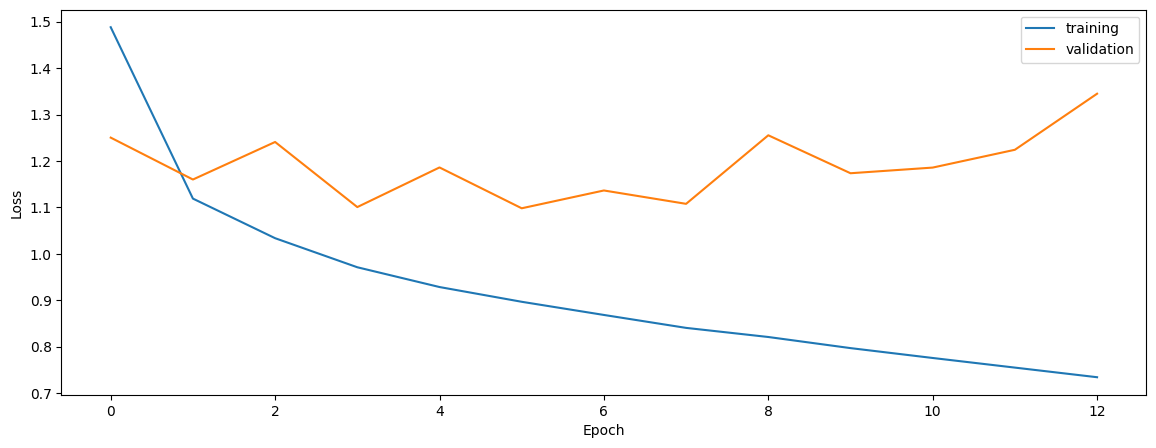

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6680636571426349
0.5706725951903807
0.6466746494797655


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

normalized


0.5606048747557287
0.5417479208382692
0.5168744649223483


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.5583301786934363
0.551168262063893
0.5229760301176427


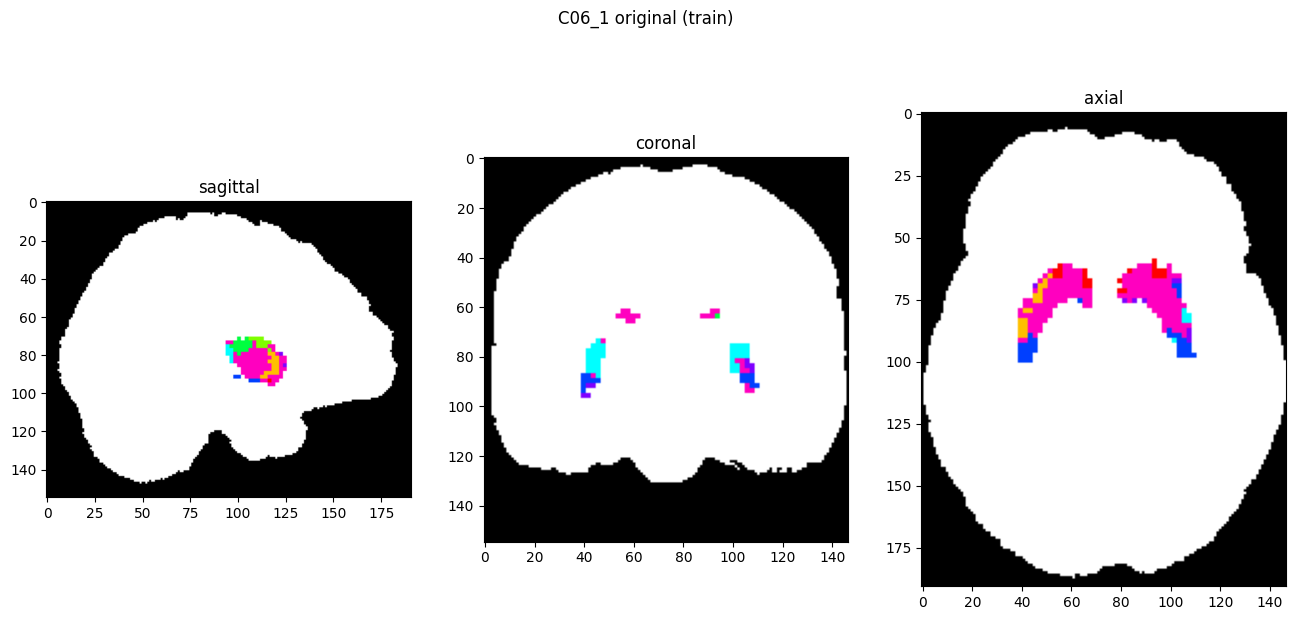

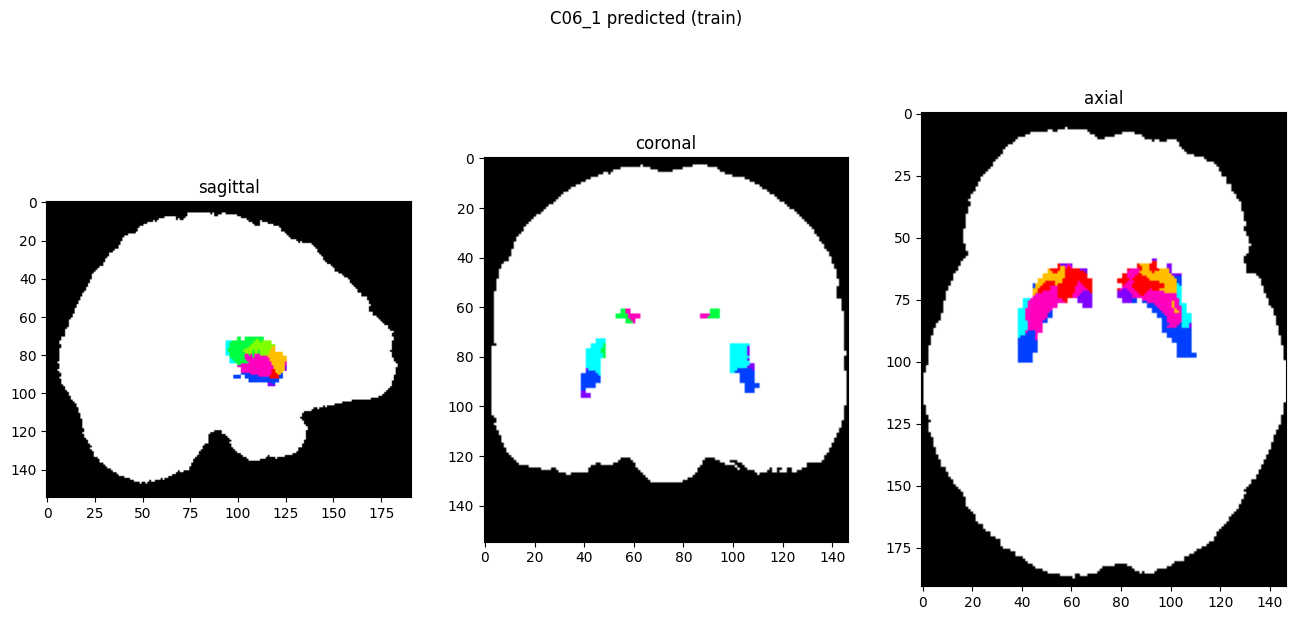

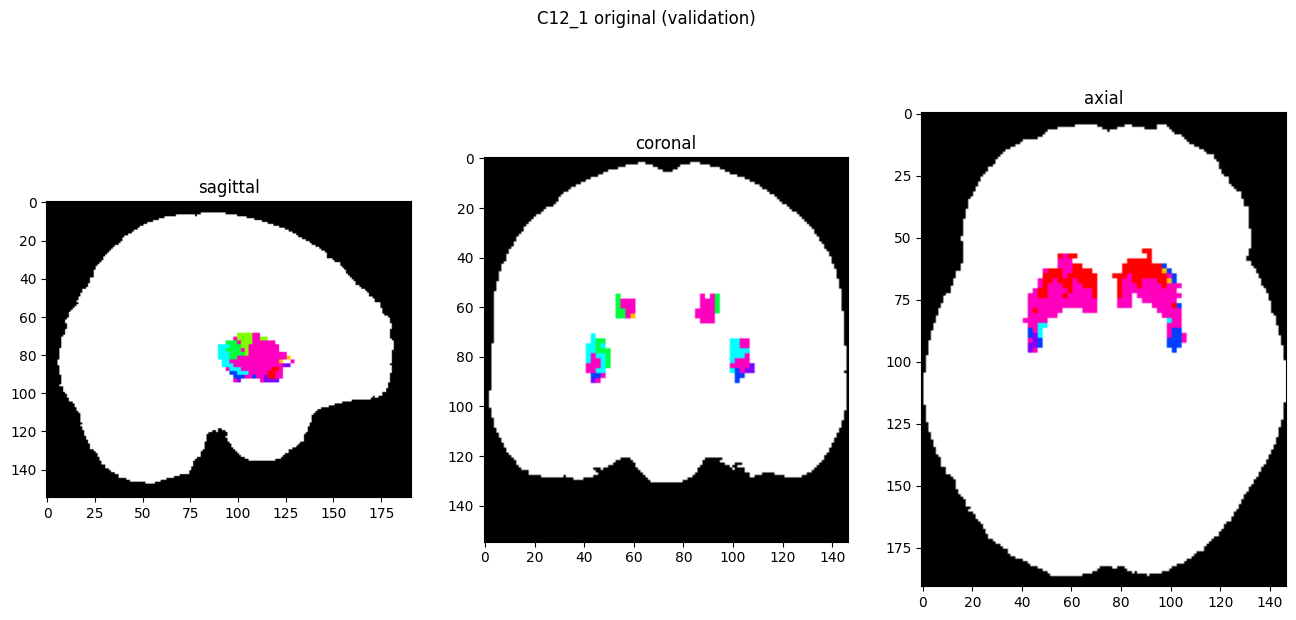

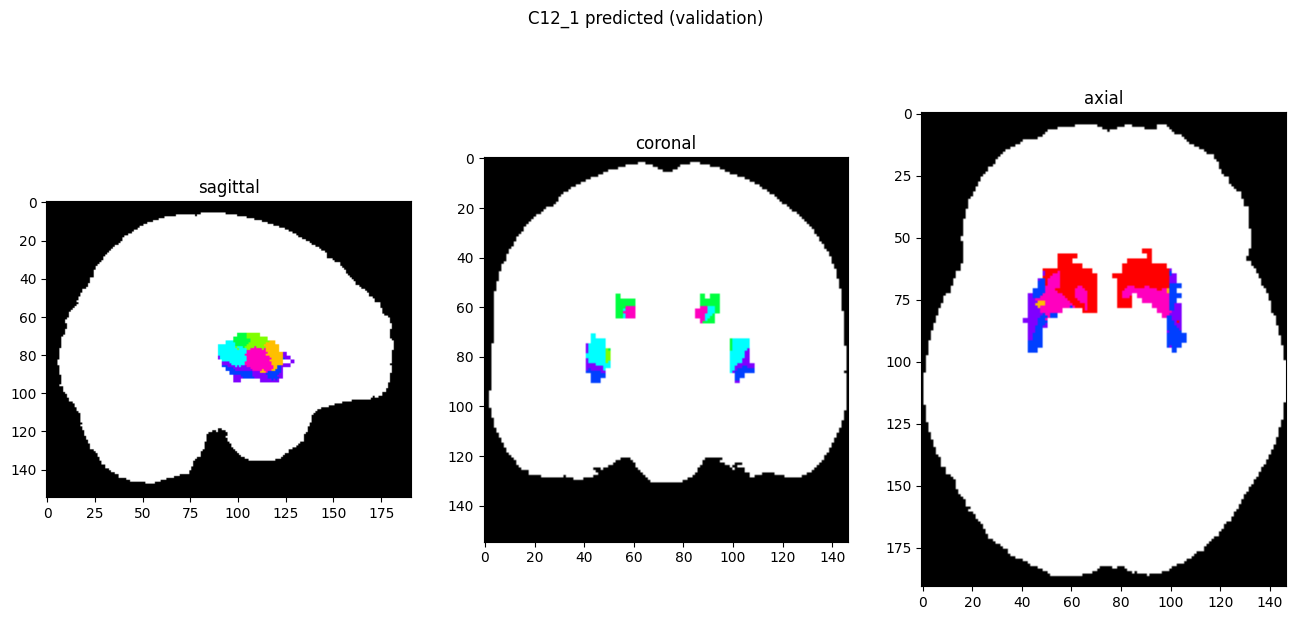

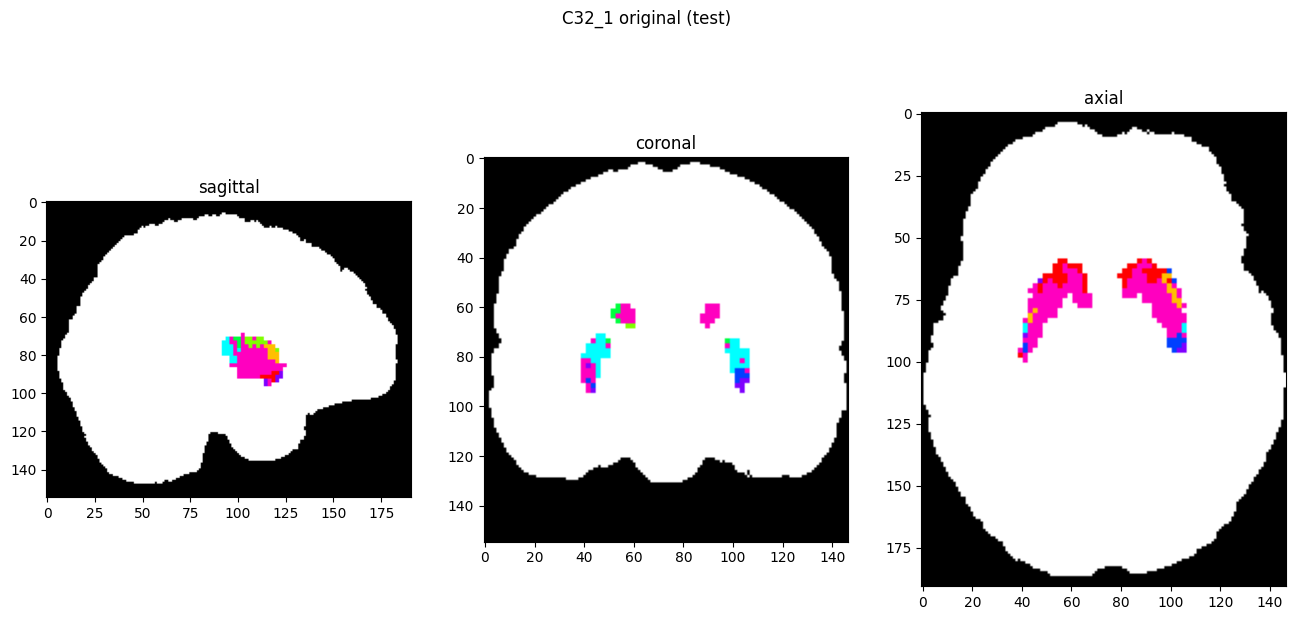

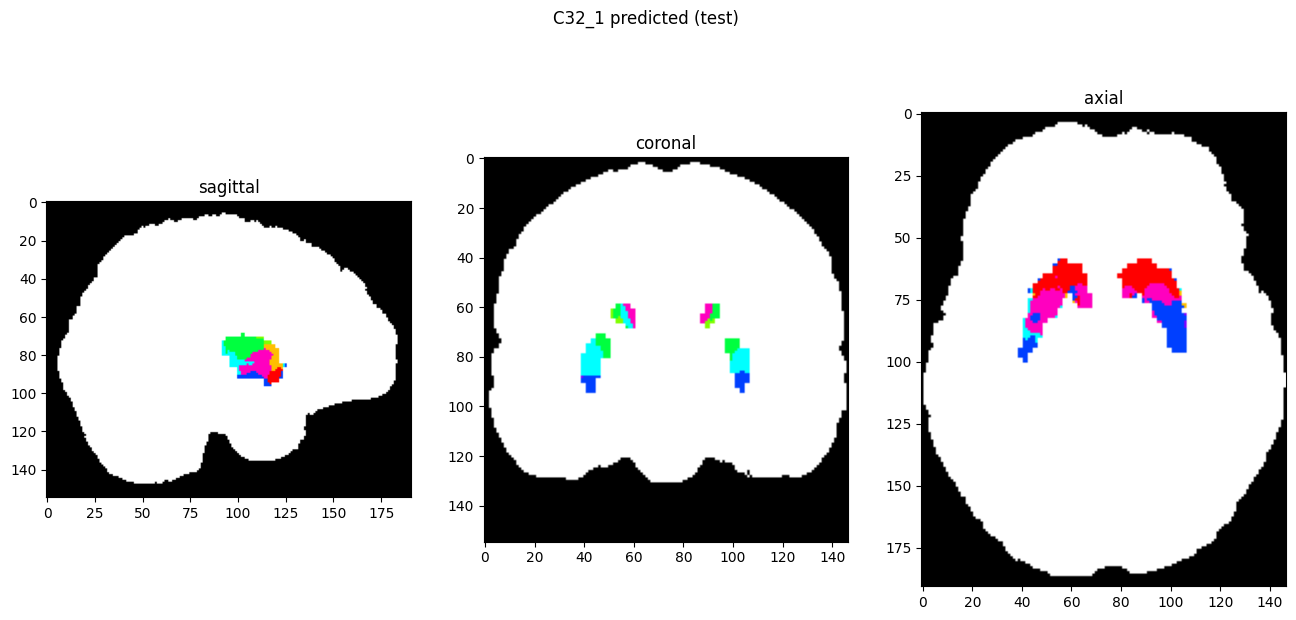

In [10]:
showResults(model, gen, threshold=0)